In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [5]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [6]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635,dx=3):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*dx,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [7]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

wmean   = wmean.where(wmean > -100)  
rhomean = rhomean.where(rhomean >0.)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

wmean_p =     change_coords_pl(hrchannel_p,wmean)[1:-4]
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [8]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
rhomean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
qmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
rhomean_s = change_coords_eta(hrchannel,rhomean_s)    
qmean_s   = change_coords_eta(hrchannel,qmean_s  )
    
    

In [9]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
lmhgt = lmchannel.HGT.isel(south_north=0,Time=-1).persist()

In [10]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [11]:
lmwmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.W_PL.days50-200.nc')
lmrhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.RHO_PL.days50-200.nc')

lmwmean   = lmwmean.where(lmwmean > -100)  
lmrhomean = lmrhomean.where(lmrhomean >0.)  
lmomegamean = -9.81*lmrhomean*lmwmean

lmwmean_p = change_coords_pl(lmchannel_p,lmwmean)
lmomegamean_p = change_coords_pl(lmchannel_p,lmomegamean)

In [10]:
lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [11]:
aqtmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.T_PL.days50-100.nc')
aqqmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.Q_PL.days50-100.nc')
aqqmean   = aqqmean.where(aqqmean >0.)  
aqtmean   = aqtmean.where(aqtmean >100.)
aqtmean_p = change_coords_pl(lmchannel_p,aqtmean)
aqqmean_p = change_coords_pl(lmchannel_p,aqqmean)

In [12]:
aqtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')
aqtmean_s   = change_coords_eta(hrchannel,aqtmean_s  ) 
aqqmean_s   = change_coords_eta(hrchannel,aqqmean_s  )

In [11]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

## 500m diagnostics

In [4]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

In [5]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')

In [7]:
capecin_list=[]
for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout*'))[21:]:
    print(file)
    c = compute_individual_cape(file)
    del(c.attrs['projection'])
    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-07-20_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-07-30_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-08-09_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-08-19_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-08-29_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-09-08_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-09-18_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-09-28_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout_d01_1970-10-08_06_00_00


In [8]:
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [9]:
%time lmchannelprecip = 4*(lmchannel.RAINNC).diff('Time').persist()
lmchannelprecip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')

CPU times: user 1.16 s, sys: 2min 53s, total: 2min 54s
Wall time: 4min 18s


In [8]:
#takes 15 min
%time lmchannelprecip_hourly = 24*(lmchannel_p.RAINNC).diff('Time').persist()
lmchannelprecip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.hourly.days0-200.nc')


CPU times: user 4.62 s, sys: 11min 6s, total: 11min 10s
Wall time: 13min 44s


In [9]:
%time lmwmean  =lmchannel_p.W_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time lmrhomean=lmchannel_p.RHO_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time lmtmean  =lmchannel_p.T_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time lmqmean  =lmchannel_p.Q_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
lmwmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.W_PL.days50-200.nc')
lmrhomean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.RHO_PL.days50-200.nc')
lmtmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')

CPU times: user 1min 45s, sys: 12min 54s, total: 14min 39s
Wall time: 10min 58s
CPU times: user 1min 45s, sys: 12min 46s, total: 14min 31s
Wall time: 11min 11s
CPU times: user 1min 48s, sys: 12min 54s, total: 14min 43s
Wall time: 10min 49s
CPU times: user 1min 46s, sys: 12min 50s, total: 14min 37s
Wall time: 10min 49s


In [10]:
%time lmumean=lmchannel_p.U_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
%time lmvmean=lmchannel_p.V_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north']).persist()
lmumean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.U_PL.days50-200.nc')
lmvmean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.V_PL.days50-200.nc')


CPU times: user 1min 45s, sys: 12min 44s, total: 14min 29s
Wall time: 10min 47s
CPU times: user 1min 49s, sys: 12min 29s, total: 14min 18s
Wall time: 10min 26s


In [11]:
%%time 
lmrhomean_s=lmchannel.RHO.isel(Time=slice(200,801)).mean(['Time','south_north']).persist()
lmqmean_s=lmchannel.QVAPOR.isel(Time=slice(200,801)).mean(['Time','south_north']).persist()
lmtemp = (lmchannel.T+300)*((lmchannel.PB+lmchannel.P)/1e5)**0.286
lmtmean_s = lmtemp.isel(Time=slice(200,801)).mean(['Time','south_north'])
lmtmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmrhomean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.RHO.days50-200.nc')
lmqmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')

CPU times: user 5min 48s, sys: 11min 53s, total: 17min 41s
Wall time: 9min 43s


In [35]:
aqchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/')

In [36]:
%%time 
aqqmean_s=aqchannel.QVAPOR.isel(Time=slice(200,801)).mean(['Time','south_north']).persist()
aqtemp = (aqchannel.T+300)*((aqchannel.PB+aqchannel.P)/1e5)**0.286
aqtmean_s = aqtemp.isel(Time=slice(200,801)).mean(['Time','south_north'])
aqtmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')

CPU times: user 1min 43s, sys: 2min 2s, total: 3min 46s
Wall time: 2min 11s


In [137]:
%%time 
lmwrms=xr.ufuncs.sqrt((lmchannel_p.W_PL.isel(Time=slice(800,4801))**2).mean(['Time','south_north'])).persist()
lmwrms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.W_PL.rms.days50-200.nc')

CPU times: user 2min 58s, sys: 34min 58s, total: 37min 57s
Wall time: 21min 46s


In [10]:
%%time 
lmurms=xr.ufuncs.sqrt((lmchannel_p.U_PL.isel(Time=slice(800,4801))**2).mean(['Time','south_north'])).persist()
lmurms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.U_PL.rms.days50-200.nc')

CPU times: user 2min 17s, sys: 11min 15s, total: 13min 33s
Wall time: 9min 15s


In [11]:
%%time 
lmvrms=xr.ufuncs.sqrt((lmchannel_p.V_PL.isel(Time=slice(800,4801))**2).mean(['Time','south_north'])).persist()
lmvrms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.V_PL.rms.days50-200.nc')

CPU times: user 2min 20s, sys: 11min 55s, total: 14min 15s
Wall time: 9min 36s


In [12]:
%%time 
urms=xr.ufuncs.sqrt((hrchannel_p.U_PL.isel(Time=slice(800,4801))**2).mean(['Time','south_north'])).persist()
urms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.rms.days50-200.nc')

CPU times: user 2min 43s, sys: 12min 47s, total: 15min 30s
Wall time: 13min 43s


In [13]:
%%time 
vrms=xr.ufuncs.sqrt((hrchannel_p.V_PL.isel(Time=slice(800,4801))**2).mean(['Time','south_north'])).persist()
vrms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.rms.days50-200.nc')

CPU times: user 2min 54s, sys: 13min 20s, total: 16min 15s
Wall time: 15min 21s


# Cross-sections

Mean upstream precip, 1000m : 4.427 mm/day
Mean upstream precip, 500m  : 4.407 mm/day
Mean precip, 1000m : 4.254 mm/day
Mean precip, 500m  : 4.267 mm/day


(-100.0, 3000.0)

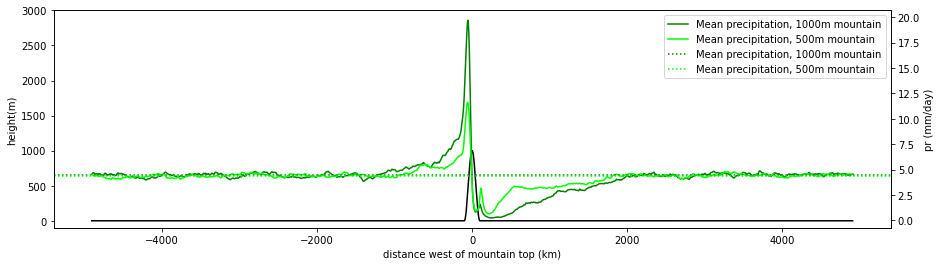

In [14]:
ax,ax2=plotsection(hrhgt)
ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannelprecip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='Mean precipitation, 1000m mountain')
ax2.plot(hrdist,lmchannelprecip.isel(Time=slice(200,1201)).mean(['south_north','Time']),color='lime' ,label='Mean precipitation, 500m mountain')
hrmeanprecip = hrchannelprecip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean()
lmmeanprecip = lmchannelprecip.isel(Time=slice(200,1201),west_east=slice(2000,3000)).mean()
ax2.axhline(hrmeanprecip,color='green',linestyle=':',label='Mean precipitation, 1000m mountain')
ax2.axhline(lmmeanprecip,color='lime' ,linestyle=':',label='Mean precipitation, 500m mountain')
print("Mean upstream precip, 1000m : %.3f mm/day"%hrmeanprecip)
print("Mean upstream precip, 500m  : %.3f mm/day"%lmmeanprecip)
print("Mean precip, 1000m : %.3f mm/day"%(hrchannelprecip.isel(Time=slice(200,801)).mean()))
print("Mean precip, 500m  : %.3f mm/day"%(lmchannelprecip.isel(Time=slice(200,1201)).mean()))

ax2.legend()
ax.set_ylim(-100,3000)

(-100.0, 3000.0)

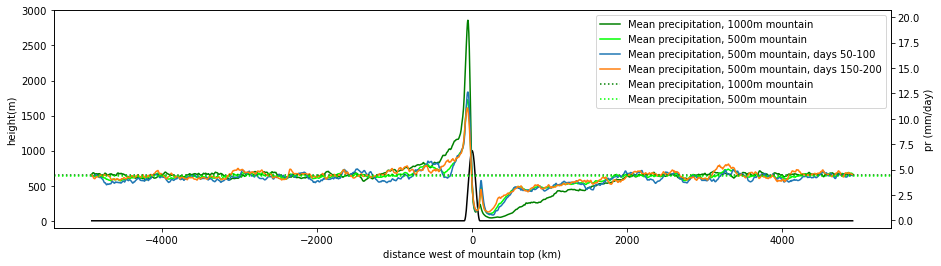

In [22]:
ax,ax2=plotsection(hrhgt)
ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannelprecip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='Mean precipitation, 1000m mountain')
ax2.plot(hrdist,lmchannelprecip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='lime' ,label='Mean precipitation, 500m mountain')
ax2.plot(hrdist,lmchannelprecip.isel(Time=slice(200,401)).mean(['south_north','Time']),label='Mean precipitation, 500m mountain, days 50-100')
ax2.plot(hrdist,lmchannelprecip.isel(Time=slice(600,801)).mean(['south_north','Time']),label='Mean precipitation, 500m mountain, days 150-200')

ax2.axhline(hrmeanprecip,color='green',linestyle=':',label='Mean precipitation, 1000m mountain')
ax2.axhline(lmmeanprecip,color='lime' ,linestyle=':',label='Mean precipitation, 500m mountain')

ax2.legend()
ax.set_ylim(-100,3000)

(-100.0, 1800.0)

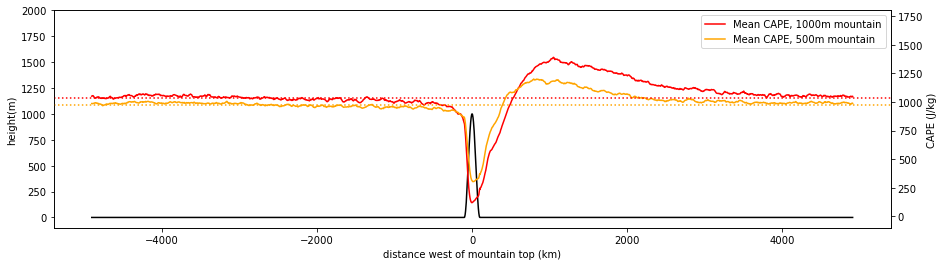

In [15]:
ax,ax2=plotsection(hrhgt)
ax2.set_ylabel("CAPE (J/kg)")

ax2.plot(hrdist,hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time']),color='r',label='Mean CAPE, 1000m mountain')
ax2.plot(hrdist,lmchannel_capecin[0].isel(Time=slice(200,1201)).mean(['south_north','Time']),color='orange',label='Mean CAPE, 500m mountain')
ax2.axhline(hrchannel_capecin[0].isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='r',linestyle=':')
ax2.axhline(lmchannel_capecin[0].isel(Time=slice(200,1200),west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')


ax2.legend()
ax.set_ylim(-100,2000)
ax2.set_ylim(-100,1800)

(-100.0, 2500.0)

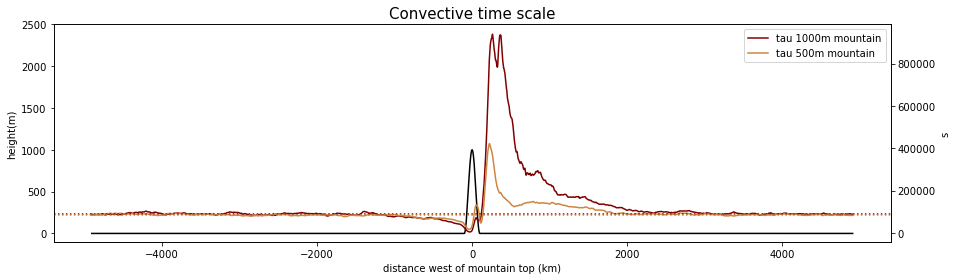

In [27]:
factor = 1/(2.26e6/86400/10000)
ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))

ax2.plot(hrdist,factor*hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['south_north','Time'])/hrchannelprecip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='maroon',label='tau 1000m mountain')
ax2.plot(hrdist,factor*lmchannel_capecin[0].isel(Time=slice(200,1201)).mean(['south_north','Time'])/lmchannelprecip.isel(Time=slice(200,1201)).mean(['south_north','Time']),color='peru',label='tau 500m mountain')
ax2.axhline(factor*hrchannel_capecin[0].isel(Time=slice(200,801),west_east=slice(2000,3000)).mean()/hrchannelprecip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),linestyle=':',color='maroon'  )
ax2.axhline(factor*lmchannel_capecin[0].isel(Time=slice(200,1201),west_east=slice(2000,3000)).mean()/lmchannelprecip.isel(Time=slice(200,1201),west_east=slice(2000,3000)).mean(),linestyle=':',color='peru')

ax2.set_title("Convective time scale", fontsize=15)
ax2.set_ylabel("s")
ax2.legend()
ax.set_ylim(-100,2500)

 CAPE = 1066.6 J/kg
 CAPE = 950.1 J/kg
 CAPE = 913.8 J/kg


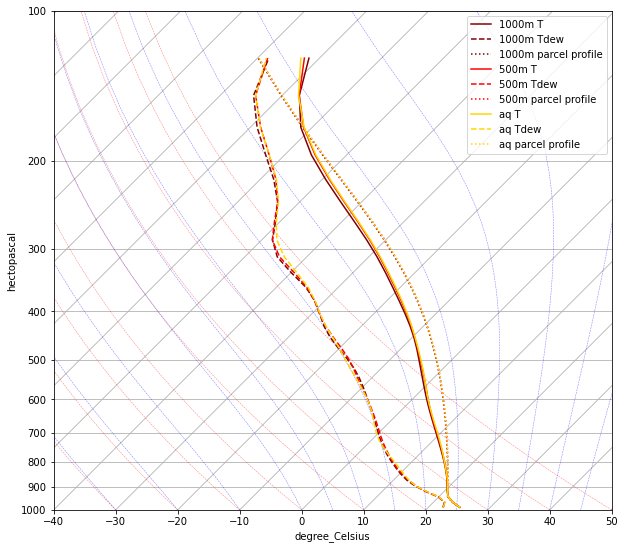

In [15]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, rotation=45)
plot_skewt(tmean_s.sel(distance_from_mtn=-3000,method='nearest'),qmean_s.sel(distance_from_mtn=-3000,method='nearest'),qmean_s.sel(distance_from_mtn=-3000,method='nearest').pressure,skew,"maroon",'1000m')
plot_skewt(lmtmean_s.sel(distance_from_mtn=-3000,method='nearest'),lmqmean_s.sel(distance_from_mtn=-3000,method='nearest'),lmqmean_s.sel(distance_from_mtn=-3000,method='nearest').pressure,skew,"red",'500m')
plot_skewt(aqtmean_s.sel(distance_from_mtn=-3000,method='nearest'),aqqmean_s.sel(distance_from_mtn=-3000,method='nearest'),aqqmean_s.sel(distance_from_mtn=-3000,method='nearest').pressure,skew,"gold",'aq')



# Theory

In [12]:
from scipy.integrate import cumtrapz
def cape_analytical_Lx(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    return CAPERCE * np.exp(-c) * (1+cumtrapz(alpha/L*np.exp(c),x,initial=0))
def precip(cape,tau_c):
    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    return conversion * M * cape / tau_c / Lc

In [13]:
hrCAPERCE = 1050
lmCAPERCE = 1000
L=450e3
hrtauc0=7e4
lmtauc0=7e4

In [14]:
# f from simulation
x = 1000*(1635-hrhgt.west_east)*3 #+ 4902000
x = x[::-1] 

hrcape=hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time'])
hrpr = hrchannelprecip.isel(Time=slice(200,800)).mean(['south_north','Time'])
hrtauc=hrcape/(2.26e6*hrpr/86400/8000)
hrfsim = np.array(hrtauc[::-1]/hrtauc.isel(west_east=slice(2000,3000)).mean())
print("baseline tau_c in hr simulation : %.1e s"%(hrtauc.isel(west_east=slice(2000,3000)).mean()))

lmcape=lmchannel_capecin[0].isel(Time=slice(200,1200)).mean(['south_north','Time'])
lmpr = lmchannelprecip.isel(Time=slice(200,1200)).mean(['south_north','Time'])
lmtauc=lmcape/(2.26e6*lmpr/86400/8000)
lmfsim = np.array(lmtauc[::-1]/lmtauc.isel(west_east=slice(2000,3000)).mean())
print("baseline tau_c in lm simulation : %.1e s"%(lmtauc.isel(west_east=slice(2000,3000)).mean()))

baseline tau_c in hr simulation : 7.2e+04 s
baseline tau_c in lm simulation : 6.8e+04 s


In [77]:
%%time
hrevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time'])
hralpha = np.array(hrevap/hrevap.mean())[::-1]

CPU times: user 811 ms, sys: 6.8 s, total: 7.61 s
Wall time: 20.9 s


In [78]:
%%time
lmevap = lmchannel.QFX.isel(Time=slice(200,1200)).mean(['south_north','Time'])
lmalpha = np.array(lmevap/lmevap.mean())[::-1]

CPU times: user 1.26 s, sys: 36.2 s, total: 37.5 s
Wall time: 58.4 s


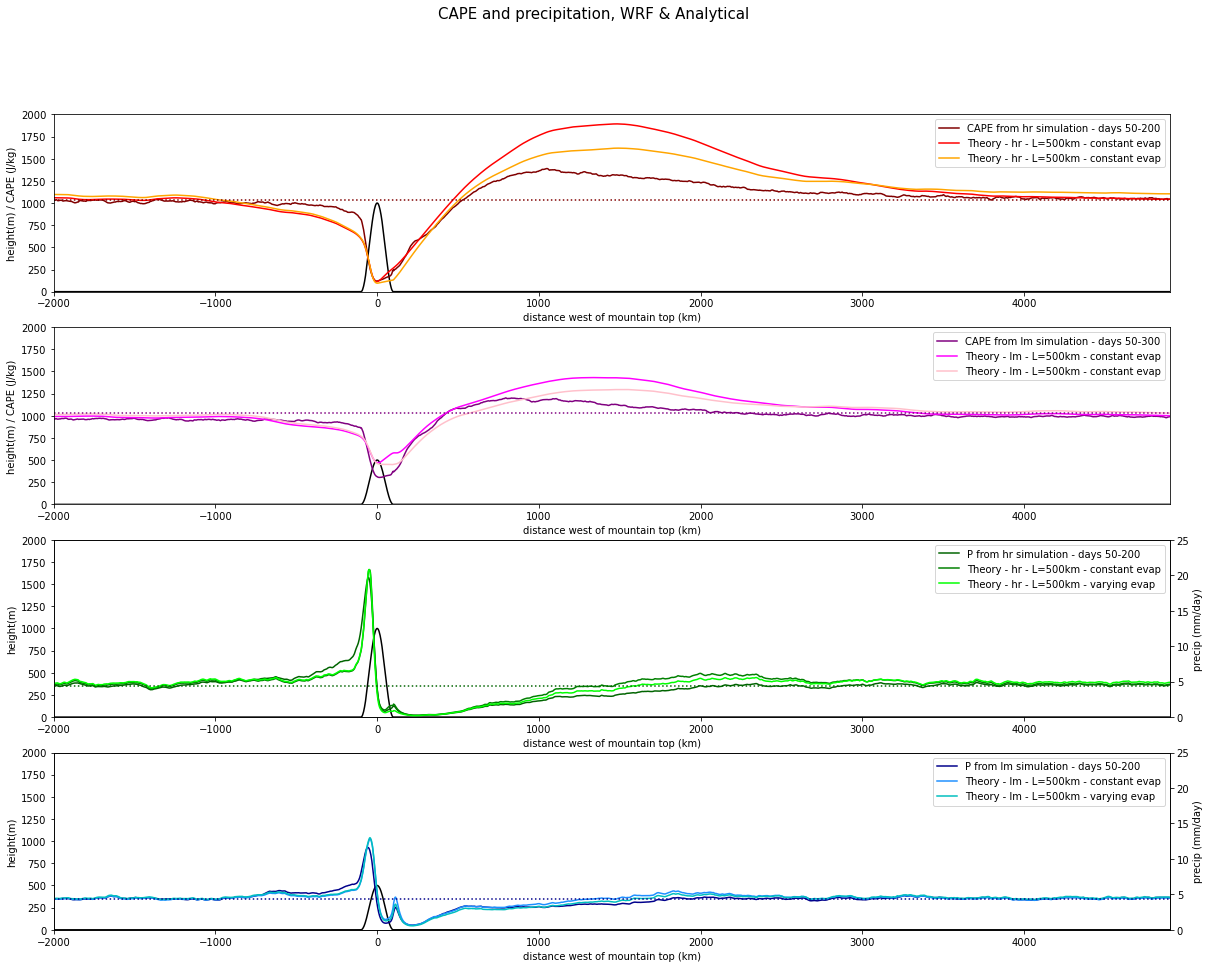

In [24]:
fig, (ax,ax1,ax2,ax3) = plt.subplots(4,1,figsize=(20,15))
for a in ax,ax1:
    a.set_xlabel("distance west of mountain top (km)")
    a.set_ylabel("height(m) / CAPE (J/kg)")
    a.set_ylim(0,2000)
    
ax.plot(hrdist,hrhgt,color='k')
ax.plot(hrdist ,hrcape,label='CAPE from hr simulation - days 50-200',color='maroon')
ax.plot(hrdist,cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,1.)[::-1],color="r",label='Theory - hr - L=500km - constant evap')
ax.plot(hrdist,cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,hralpha)[::-1],color="orange",label='Theory - hr - L=500km - constant evap')
ax.axhline(hrcape[2000:3000].mean(),linestyle=':',color='maroon')


ax1.plot(hrdist,lmhgt,color='k')
ax1.plot(hrdist ,lmcape,label='CAPE from lm simulation - days 50-300',color='purple')
ax1.plot(hrdist,cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,1.)[::-1],color="magenta",label='Theory - lm - L=500km - constant evap')
ax1.plot(hrdist,cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,lmalpha)[::-1],color="pink",label='Theory - lm - L=500km - constant evap')
ax1.axhline(hrcape[2000:3000].mean(),linestyle=':',color='purple')

for a in ax2,ax3:
    a.set_xlabel("distance west of mountain top (km)")
    a.set_ylabel("height(m)")
    a.set_ylim(0,2000)
ax22=ax2.twinx()
ax32=ax3.twinx()

for a in ax22,ax32:
    a.set_ylabel("precip (mm/day)")
    a.set_ylabel("precip (mm/day)")
    a.set_ylim(0,25)

ax2.plot(hrdist,hrhgt,color='k')
ax22.plot(hrdist,hrpr,label='P from hr simulation - days 50-200',color='darkgreen')
ax22.plot(hrdist,precip(cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,1.),hrtauc0*hrfsim)[::-1],color="g",label='Theory - hr - L=500km - constant evap')
ax22.plot(hrdist,precip(cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,hralpha),hrtauc0*hrfsim)[::-1],color="lime",label='Theory - hr - L=500km - varying evap')
ax22.axhline(hrpr[2000:3000].mean(),linestyle=':',color='darkgreen')

ax3.plot(hrdist,lmhgt,color='k')
ax32.plot(hrdist,lmpr,label='P from lm simulation - days 50-200',color='darkblue')
ax32.plot(hrdist,precip(cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,1.),lmtauc0*lmfsim)[::-1],color="dodgerblue",label='Theory - lm - L=500km - constant evap')
ax32.plot(hrdist,precip(cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,lmalpha),lmtauc0*lmfsim)[::-1],color="c" ,label='Theory - lm - L=500km - varying evap')
ax32.axhline(lmpr[2000:3000].mean(),linestyle=':',color='darkblue')

fig.suptitle("CAPE and precipitation, WRF & Analytical", fontsize=15)
for a in ax,ax1,ax22,ax32:
    a.legend()
    a.set_xlim(-2000,4900)

# Experiments on $\tau'$

In [16]:
lmfsim_modified=lmfsim.copy()
a=1740
b=1900
lmfsim_modified[a:b]=lmfsim_modified[a] + (lmfsim_modified[b]-lmfsim_modified[a])*np.linspace(0,1,b-a)

(-1500.0, 2000.0)

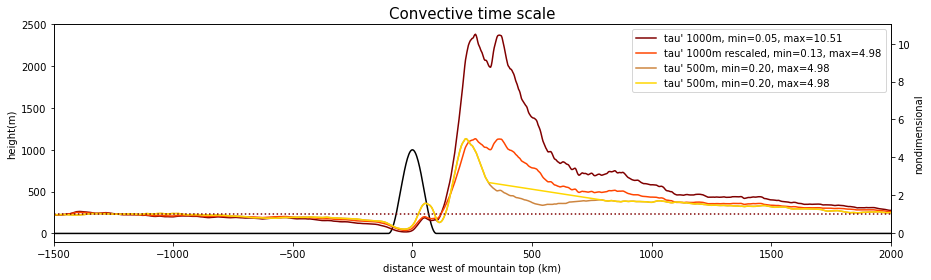

In [55]:
factor = 1/(2.26e6/86400/10000)
ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))

def plottc(tc,color,desc):
    ax2.plot(hrdist,tc[::-1],color=color,label=desc+', min=%.2f, max=%.2f'%(tc.min(),tc.max()))

plottc(hrfsim,'maroon',"tau' 1000m")
plottc(hrfsim**(np.log(lmfsim).max()/np.log(hrfsim).max()),'orangered',"tau' 1000m rescaled")
#plottc(hrfsim**(np.log(lmfsim).min()/np.log(hrfsim).min()),'blue','tau 1000m rescaled')
plottc(lmfsim,'peru',"tau' 500m")
plottc(lmfsim_modified,'gold',"tau' 500m")


ax2.axhline(1.,linestyle=':',color='maroon'  )


ax2.set_title("Convective time scale", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_ylim(-100,2500)
ax.set_xlim(-1500,2000)

(0.0, 25.0)

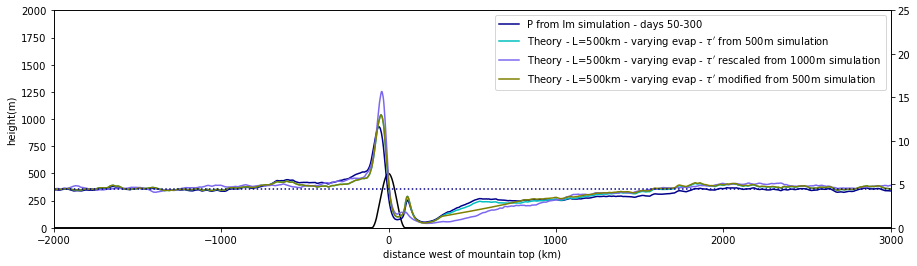

In [17]:
ax,ax2=plotsection(lmhgt)
#ax2.plot(hrdist,hrpr,label='P from hr simulation - days 50-200',color='darkgreen')
ax2.plot(hrdist,lmpr,label='P from lm simulation - days 50-300',color='darkblue')
ax2.plot(hrdist,precip(cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,lmalpha),lmtauc0*lmfsim)[::-1],color="c" ,label=r"Theory - L=500km - varying evap - $\tau'$ from 500m simulation")
ax2.plot(hrdist,precip(cape_analytical_Lx(x,hrfsim**(np.log(lmfsim).max()/np.log(hrfsim).max()),L,lmCAPERCE,lmalpha),lmtauc0*hrfsim**(np.log(lmfsim).max()/np.log(hrfsim).max()))[::-1],color="mediumslateblue" ,label=r"Theory - L=500km - varying evap - $\tau'$ rescaled from 1000m simulation")
ax2.plot(hrdist,precip(cape_analytical_Lx(x,lmfsim_modified,L,lmCAPERCE,lmalpha),lmtauc0*lmfsim_modified)[::-1],color="olive" ,label=r"Theory - L=500km - varying evap - $\tau'$ modified from 500m simulation")

ax2.axhline(lmpr[2000:3000].mean(),linestyle=':',color='darkblue')
ax.set_xlim(-2000,3000)
ax2.legend()
ax.set_ylim(0.,2000.)
ax2.set_ylim(0.,25.)

In [16]:
hrcin=hrchannel_capecin[1].isel(Time=slice(200,800)).mean(['south_north','Time']).persist()
lmcin=lmchannel_capecin[1].isel(Time=slice(200,1200)).mean(['south_north','Time']).persist()
hrcin_adim=hrcin/hrcin[2000:3000].mean()
lmcin_adim=lmcin/lmcin[2000:3000].mean()

(-1500.0, 2000.0)

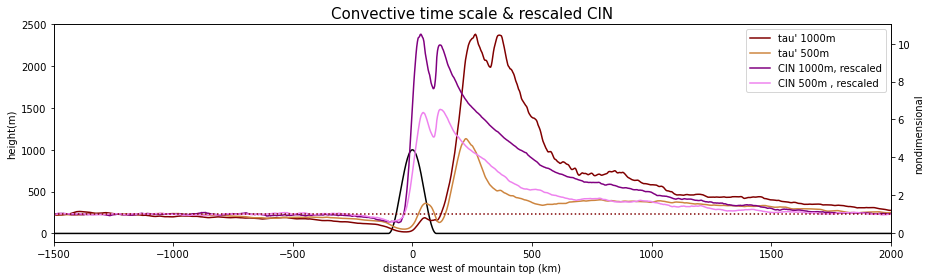

In [17]:
factor = 1/(2.26e6/86400/10000)
ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))

ax2.plot(hrdist,hrfsim[::-1],color='maroon',label="tau' 1000m")
ax2.plot(hrdist,lmfsim[::-1],color='peru',label="tau' 500m")

ax2.plot(hrdist,hrcin_adim**(np.log(hrfsim).max()/np.log(hrcin_adim).max()),color='purple',label='CIN 1000m, rescaled')
ax2.plot(hrdist,lmcin_adim**(np.log(hrfsim).max()/np.log(hrcin_adim).max()),color='violet',label='CIN 500m , rescaled')

ax2.axhline(1.,linestyle=':',color='maroon'  )


ax2.set_title("Convective time scale & rescaled CIN", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_ylim(-100,2500)
ax.set_xlim(-1500,2000)

By analogy with $Q_c = \mathrm{CAPE}/\tau_c$, this amounts to $\tau_c \propto \exp( \mathrm{CIN}/K)$

This has some backing in statistical physics, where the probability of a particle being in a state of energy $E$ is $\propto \exp(-\frac{E}{k_B T})$. $k_B T$ is the mean energy of particles, and its analog here is $K$. The probability of a particle having energy higher than CIN is $\propto \exp(-\mathrm{CIN}/K)$

However this is not the type of behavior we are observing here : We would like something of the form 
$\log(\tau_c) = \alpha + \beta \log( \mathrm{CIN}/K)$, i.e. $\tau_c = \gamma (\mathrm{CIN}/K)^\beta$

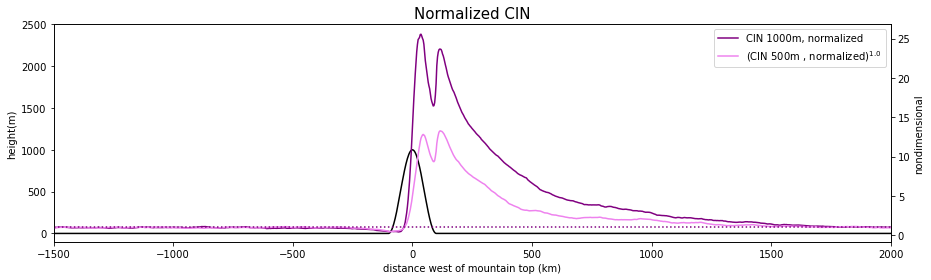

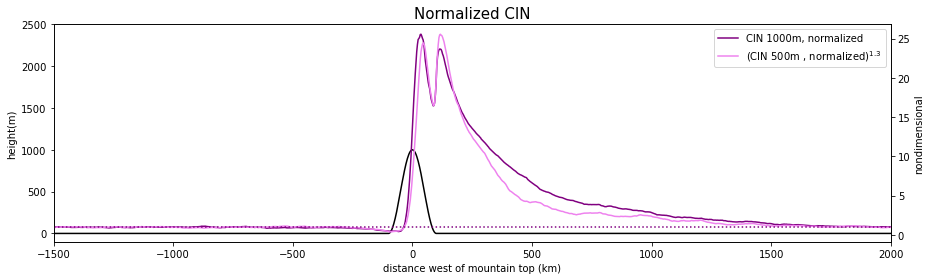

In [59]:
for power in 1,(np.log(hrcin_adim).max()/np.log(lmcin_adim).max()):
    ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))
    ax2.plot(hrdist,hrcin_adim,color='purple',label='CIN 1000m, normalized')
    ax2.plot(hrdist,lmcin_adim**power,color='violet',label=r'(CIN 500m , normalized)$^{%.1f}$'%power)
    ax2.axhline(1.,linestyle=':',color='purple'  )
    ax2.set_title("Normalized CIN", fontsize=15)
    ax2.set_ylabel("nondimensional")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)


In [48]:
hrlfc=hrchannel_capecin[3].isel(Time=slice(200,800)).mean(['south_north','Time']).persist()
lmlfc=lmchannel_capecin[3].isel(Time=slice(200,1200)).mean(['south_north','Time']).persist()
hrlfc_adim=hrlfc/hrlfc[2000:3000].mean()
lmlfc_adim=lmlfc/lmlfc[2000:3000].mean()
hrcape_adim=hrcape/hrcape[2000:3000].mean()
lmcape_adim=lmcape/lmcape[2000:3000].mean()

(-100.0, 2500.0)

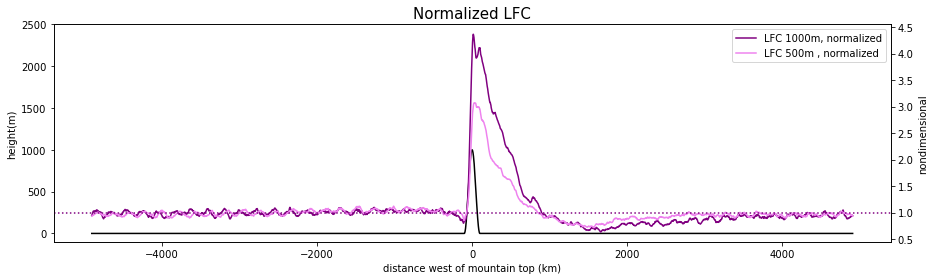

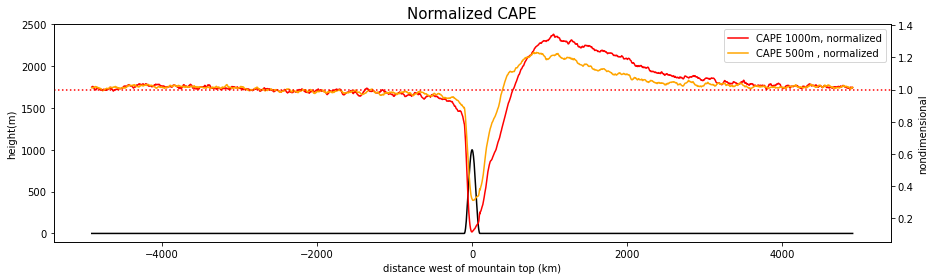

In [53]:
ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))

ax2.plot(hrdist,hrlfc_adim,color='purple',label='LFC 1000m, normalized')
ax2.plot(hrdist,lmlfc_adim,color='violet',label='LFC 500m , normalized')
ax2.axhline(1.,linestyle=':',color='purple'  )
ax2.set_title("Normalized LFC", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_ylim(-100,2500)

ax,ax2=plotsection(hrhgt)
ax2.plot(hrdist,hrcape_adim,color='red',label='CAPE 1000m, normalized')
ax2.plot(hrdist,lmcape_adim,color='orange',label='CAPE 500m , normalized')
#ax2.plot(hrdist,1/hrlfc_adim,color='purple',label='1/(LFC 1000m, normalized)')
#ax2.plot(hrdist,1/lmlfc_adim,color='violet',label='1/(LFC 500m , normalized)')
ax2.axhline(1.,linestyle=':',color='red'  )
ax2.set_title("Normalized CAPE", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_ylim(-100,2500)

# Other cross-sections

The thing to explain : why does the $\tau'$ profile go back down after 500km in the 1000m simulation, but only after 250km in the 500m simulation.

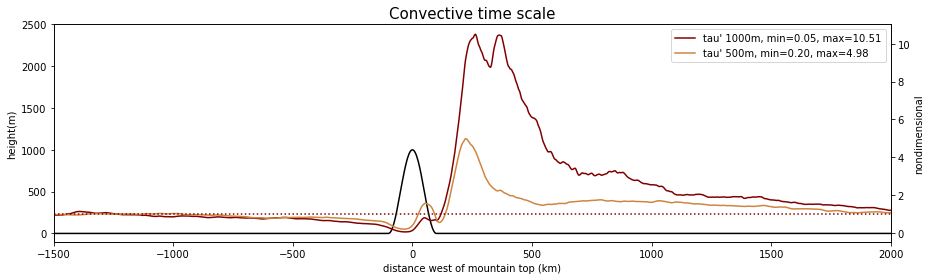

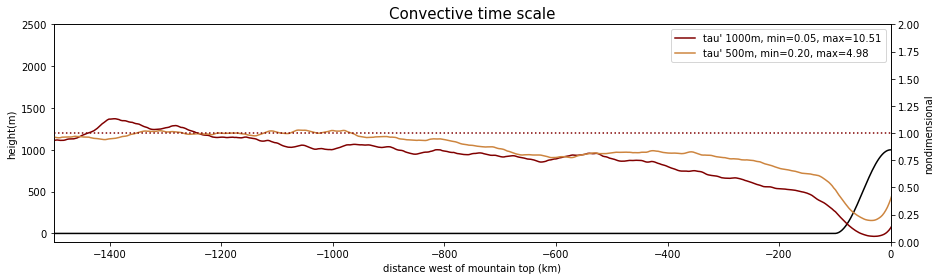

In [85]:
def plottc(tc,color,desc):
    ax2.plot(hrdist,tc[::-1],color=color,label=desc+', min=%.2f, max=%.2f'%(tc.min(),tc.max()))

for xlim,ylim in [((-1500,2000),(None,None)),((-1500,0),(0,2))]:
    ax,ax2=plotsection(hrhgt)#,figsize=(15,3.5))
    plottc(hrfsim,'maroon',"tau' 1000m")
    plottc(lmfsim,'peru',"tau' 500m")
    ax2.axhline(1.,linestyle=':',color='maroon'  )
    ax2.set_title("Convective time scale", fontsize=15)
    ax2.set_ylabel("nondimensional")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(*xlim)
    ax2.set_ylim(*ylim)

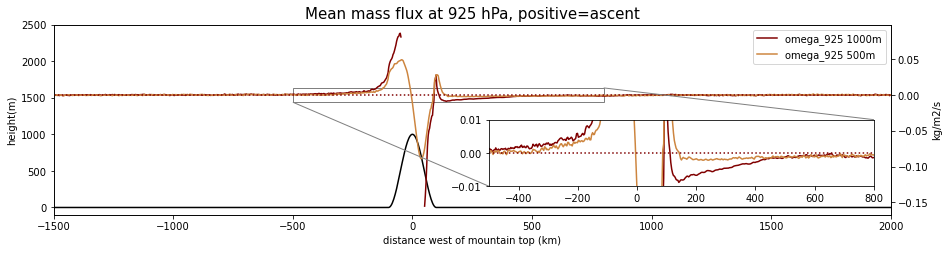

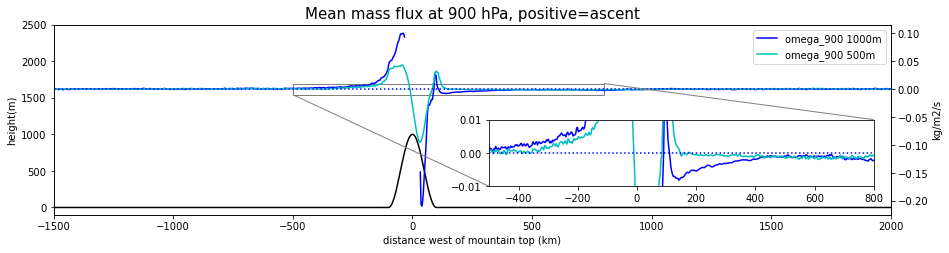

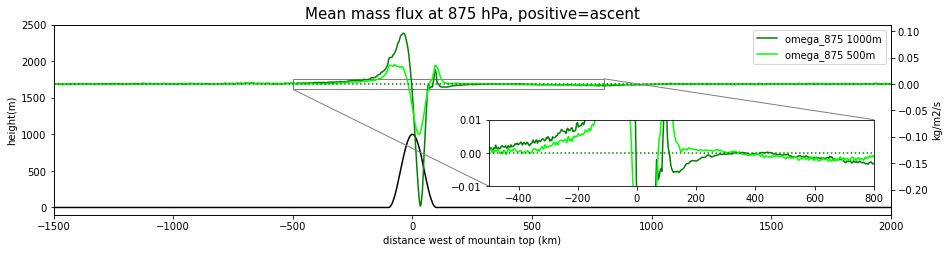

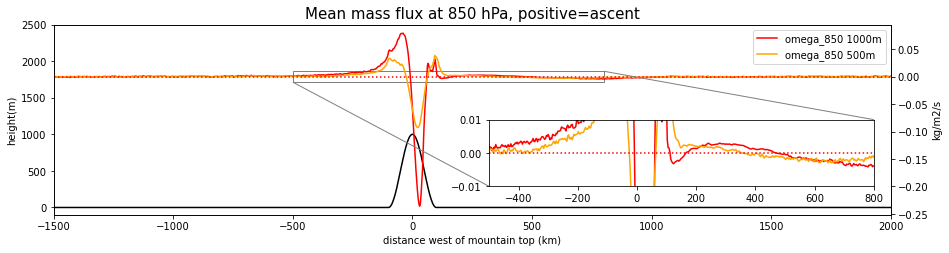

In [68]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    ax2.plot(hrdist,-  omegamean_p.sel(pressure=lev)/9.81  ,color=colors[0],label="omega_%i 1000m"%lev)#/omegamean_p.sel(pressure=lev)[2000:3000].mean()  
    ax2.plot(hrdist,-lmomegamean_p.sel(pressure=lev)/9.81,color=colors[1],label="omega_%i 500m "%lev)  #/lmomegamean_p.sel(pressure=lev)[2000:3000].mean()
    ax2.axhline(0.,linestyle=':',color=colors[0]  )
    ax2.set_title("Mean mass flux at %i hPa, positive=ascent"%lev, fontsize=15)
    ax2.set_ylabel("kg/m2/s")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    
    ax3 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax2, [0.52,0.15,0.46,0.35])
    ax3.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax2, ax3, loc1=3, loc2=1, fc="none", ec='0.5')
    
    ax3.plot(hrdist,-  omegamean_p.sel(pressure=lev)/9.81  ,color=colors[0],label="omega_%i 1000m"%lev)
    ax3.plot(hrdist,-lmomegamean_p.sel(pressure=lev)/9.81,color=colors[1],label="omega_%i 500m "%lev)  
    ax3.axhline(0.,linestyle=':',color=colors[0]  )
    ax3.set_xlim(-500,800)
    ax3.set_ylim(-0.01,0.01)



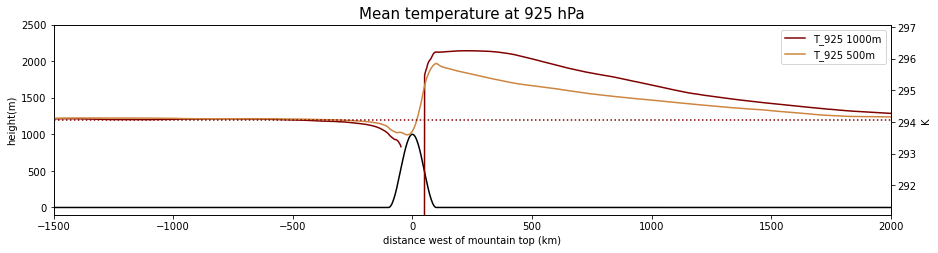

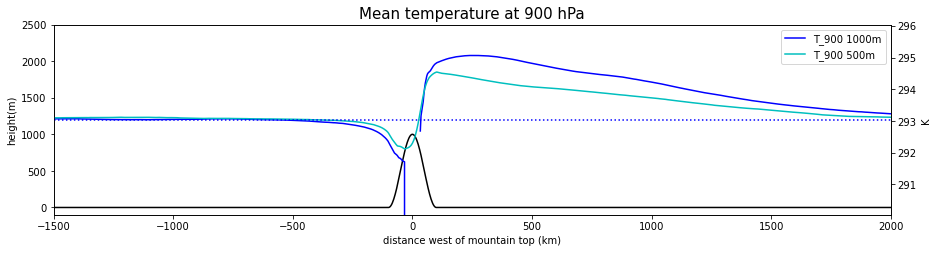

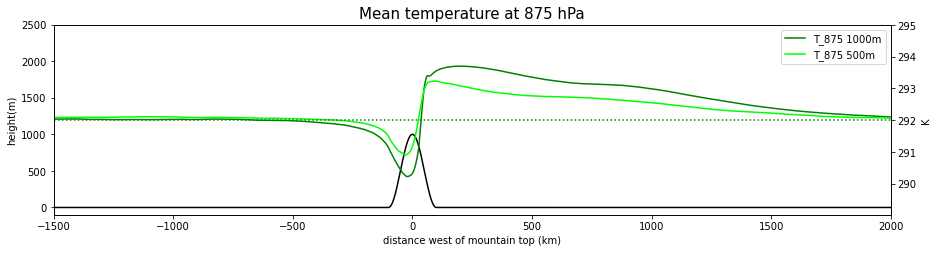

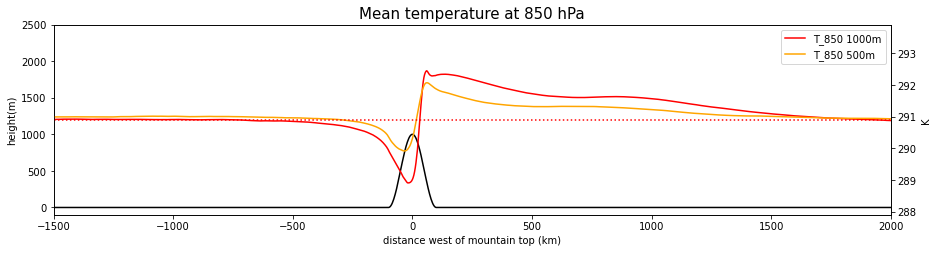

In [67]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    Tscale=tmean_p.sel(pressure=lev)[2000:3000].mean()
    ax2.plot(hrdist,  tmean_p.sel(pressure=lev),color=colors[0],label="T_%i 1000m"%lev)#/omegamean_p.sel(pressure=lev)[2000:3000].mean()  
    ax2.plot(hrdist,lmtmean_p.sel(pressure=lev),color=colors[1],label="T_%i 500m "%lev)  #/lmomegamean_p.sel(pressure=lev)[2000:3000].mean()
    ax2.axhline(Tscale,linestyle=':',color=colors[0]  )
    ax2.set_title("Mean temperature at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("K")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(Tscale-3,Tscale+3)


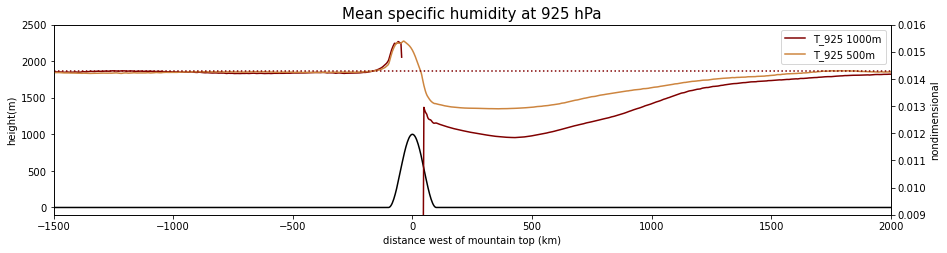

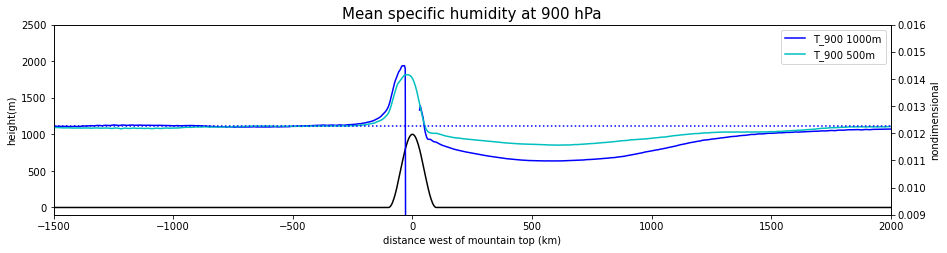

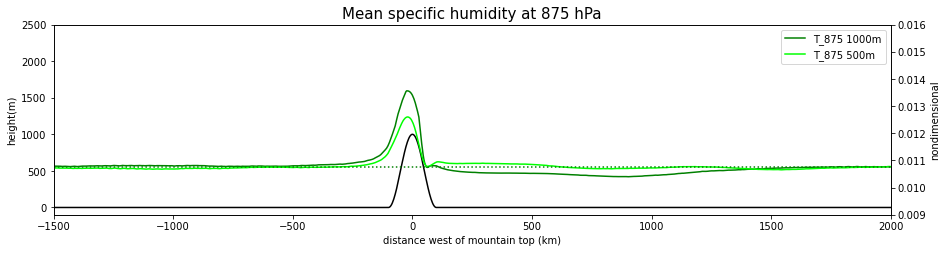

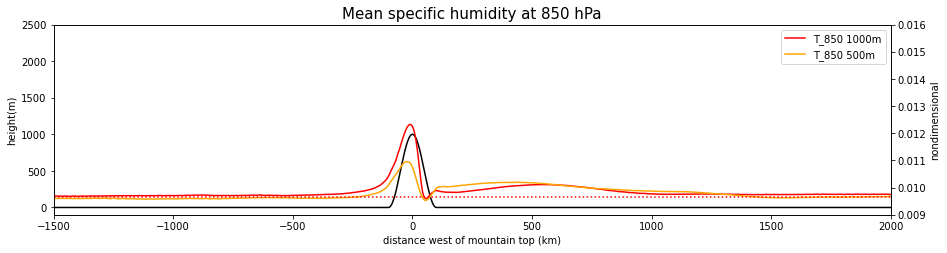

In [112]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    Qscale=qmean_p.sel(pressure=lev)[2000:3000].mean()
    ax2.plot(hrdist,  qmean_p.sel(pressure=lev),color=colors[0],label="T_%i 1000m"%lev)#/omegamean_p.sel(pressure=lev)[2000:3000].mean()  
    ax2.plot(hrdist,lmqmean_p.sel(pressure=lev),color=colors[1],label="T_%i 500m "%lev)  #/lmomegamean_p.sel(pressure=lev)[2000:3000].mean()
    ax2.axhline(Qscale,linestyle=':',color=colors[0]  )
    ax2.set_title("Mean specific humidity at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("nondimensional")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(0.009,0.016)


In [24]:
wrms=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.rms.days50-200.nc")
wrms=change_coords_pl(hrchannel_p,wrms)[1:-4]
wrms=wrms.where(wrms<5)

lmwrms=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.W_PL.rms.days50-200.nc")
lmwrms=change_coords_pl(lmchannel_p,lmwrms)
lmwrms=lmwrms.where(lmwrms<5)

In [22]:
wmean_p=change_coords_pl(hrchannel_p,wmean)[1:-4]
lmwmean_p=change_coords_pl(lmchannel_p,lmwmean)[1:-4]

In [28]:
wstd = xr.ufuncs.sqrt(wrms**2-wmean_p**2)
lmwstd = xr.ufuncs.sqrt(lmwrms**2-lmwmean_p**2)

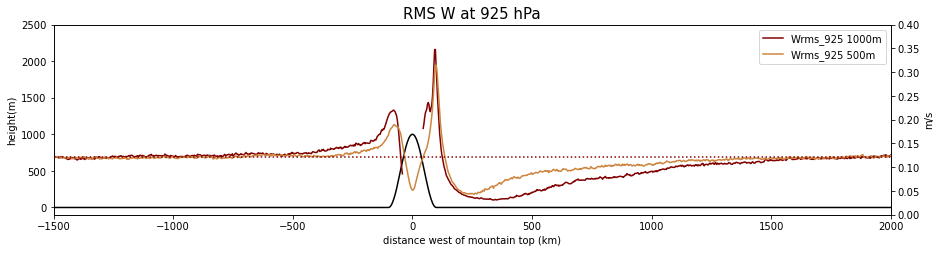

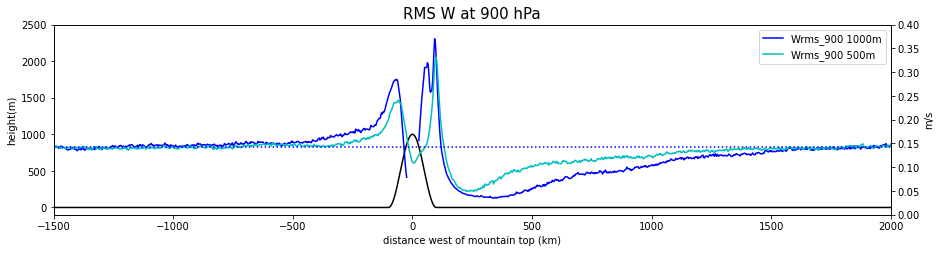

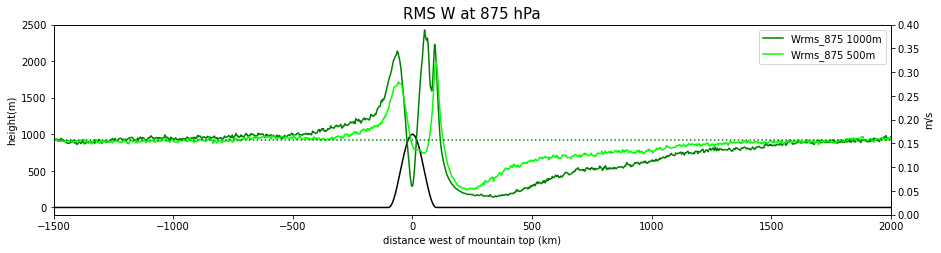

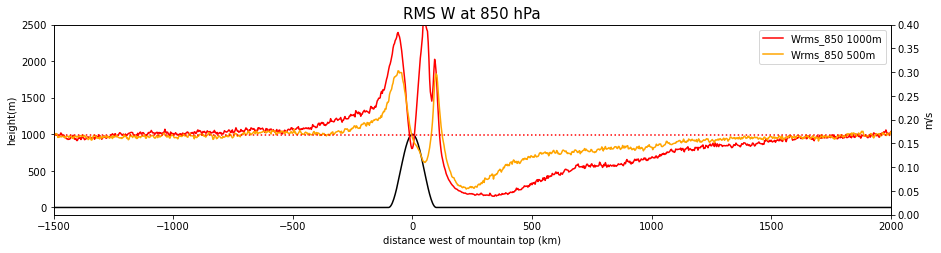

In [66]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    ax2.plot(hrdist,  wrms.sel(pressure=lev),color=colors[0],label="Wrms_%i 1000m"%lev)
    #ax2.plot(hrdist,  wstd.sel(pressure=lev),color=colors[0],linestyle='--',label="Wstd_%i 1000m"%lev)
    ax2.plot(hrdist,lmwrms.sel(pressure=lev),color=colors[1],label="Wrms_%i 500m"%lev)
    #ax2.plot(hrdist,lmwstd.sel(pressure=lev),color=colors[1],linestyle='--',label="Wstd_%i 500m"%lev)
    ax2.axhline(wrms.sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[0]  )
    ax2.set_title("RMS W at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("m/s")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(0.,0.4)


In [53]:
umean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
vmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days50-200.nc')
umean = change_coords_pl(hrchannel_p,umean.where(umean > -20))[1:-4] 
vmean = change_coords_pl(hrchannel_p,vmean.where(vmean > -20))[1:-4] 
urms  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.rms.days50-200.nc")
vrms  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.rms.days50-200.nc")
urms  = change_coords_pl(hrchannel_p,urms.where(urms<20))[1:-4]
vrms  = change_coords_pl(hrchannel_p,vrms.where(vrms<20))[1:-4]
ustd = xr.ufuncs.sqrt(urms**2-umean**2)
vstd = xr.ufuncs.sqrt(vrms**2-vmean**2)

lmumean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.U_PL.days50-200.nc')
lmvmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.V_PL.days50-200.nc')
lmumean = change_coords_pl(lmchannel_p,lmumean.where(lmumean > -20))[1:-4] 
lmvmean = change_coords_pl(lmchannel_p,lmvmean.where(lmvmean > -20))[1:-4] 
lmurms  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.U_PL.rms.days50-200.nc")
lmvrms  = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.V_PL.rms.days50-200.nc")
lmurms  = change_coords_pl(lmchannel_p,lmurms.where(lmurms<20))[1:-4]
lmvrms  = change_coords_pl(lmchannel_p,lmvrms.where(lmvrms<20))[1:-4]
lmustd = xr.ufuncs.sqrt(lmurms**2-lmumean**2)
lmvstd = xr.ufuncs.sqrt(lmvrms**2-lmvmean**2)


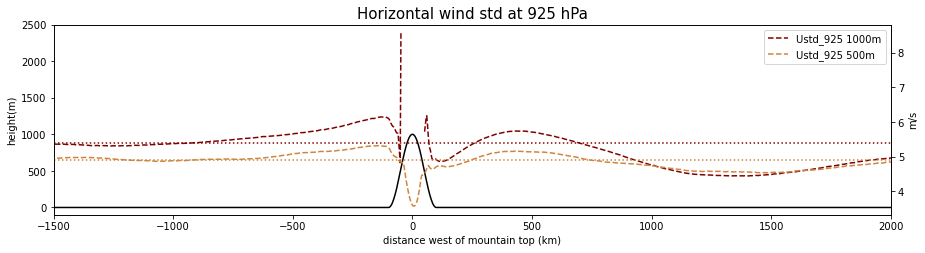

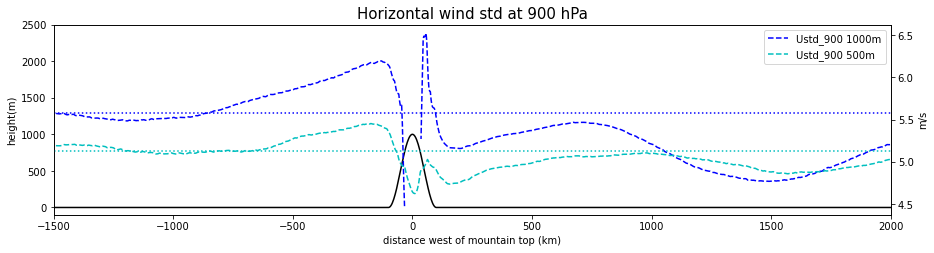

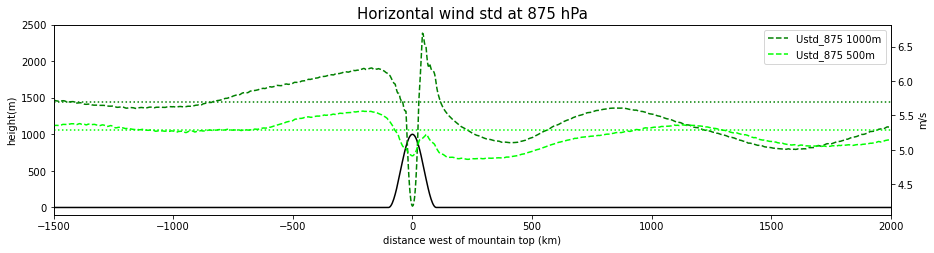

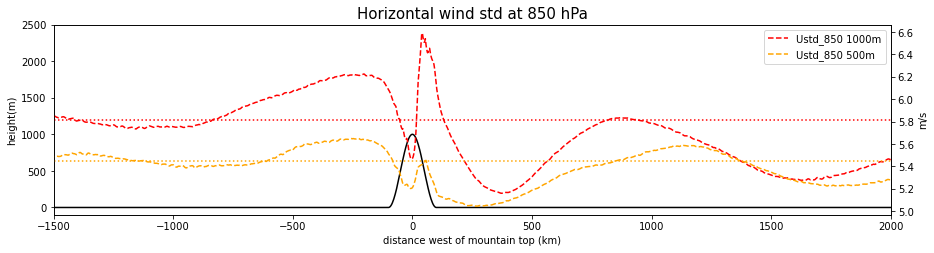

In [65]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    
    ax2.plot(hrdist,xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=lev),color=colors[0],linestyle='--',label="Ustd_%i 1000m"%lev)
    ax2.plot(hrdist,xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=lev),color=colors[1],linestyle='--',label="Ustd_%i 500m"%lev)
    ax2.axhline(xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[0]  )
    ax2.axhline(xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[1]  )
        
    
    ax2.set_title("Horizontal wind std at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("m/s")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    #ax2.set_ylim(0.,0.4)


In [70]:
ustd.pressure.sel(pressure=slice(975,850))

<xarray.DataArray 'pressure' (pressure: 6)>
array([975., 950., 925., 900., 875., 850.], dtype=float32)
Coordinates:
  * pressure  (pressure) float32 975.0 950.0 925.0 900.0 875.0 850.0

(-1500.0, 2000.0)

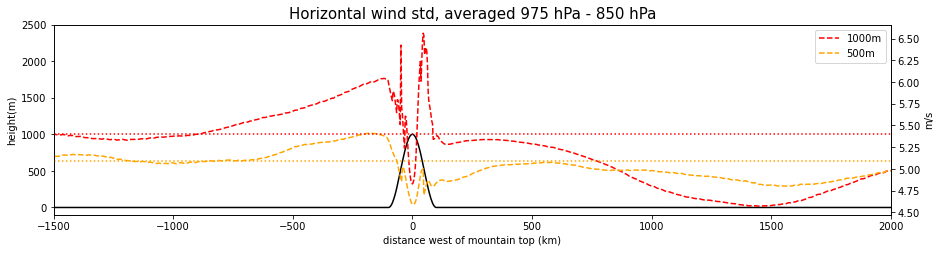

In [73]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    
ax2.plot(hrdist,xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=slice(975,850)).mean('pressure'),color=colors[0],linestyle='--',label="1000m")
ax2.plot(hrdist,xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=slice(975,850)).mean('pressure'),color=colors[1],linestyle='--',label="500m")
ax2.axhline(xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=slice(975,850))[:,2000:3000].mean(),linestyle=':',color=colors[0]  )
ax2.axhline(xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=slice(975,850))[:,2000:3000].mean(),linestyle=':',color=colors[1]  )
    
ax2.set_title("Horizontal wind std, averaged 975 hPa - 850 hPa", fontsize=15)
ax2.set_ylabel("m/s")
ax2.legend()
ax.set_ylim(-100,2500)
ax.set_xlim(-1500,2000)
#ax2.set_ylim(0.,0.4)


(0.0, 7.0)

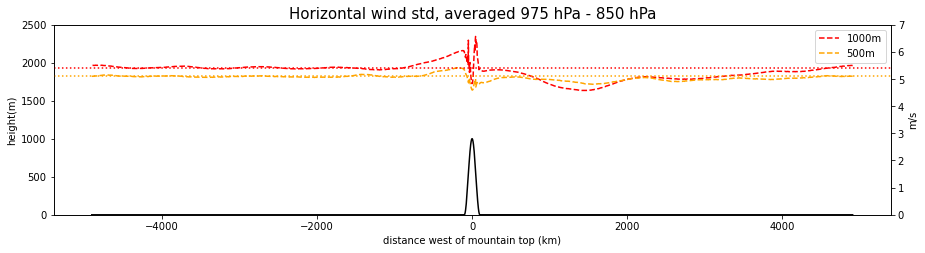

In [87]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    
ax2.plot(hrdist,xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=slice(975,850)).mean('pressure'),color=colors[0],linestyle='--',label="1000m")
ax2.plot(hrdist,xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=slice(975,850)).mean('pressure'),color=colors[1],linestyle='--',label="500m")
ax2.axhline(xr.ufuncs.sqrt(  ustd**2+  vstd**2).sel(pressure=slice(975,850))[:,2000:3000].mean(),linestyle=':',color=colors[0]  )
ax2.axhline(xr.ufuncs.sqrt(lmustd**2+lmvstd**2).sel(pressure=slice(975,850))[:,2000:3000].mean(),linestyle=':',color=colors[1]  )
    
ax2.set_title("Horizontal wind std, averaged 975 hPa - 850 hPa", fontsize=15)
ax2.set_ylabel("m/s")
ax2.legend()
ax.set_ylim(0,2500)
ax2.set_ylim(0,7)


# Vertical motion profiles

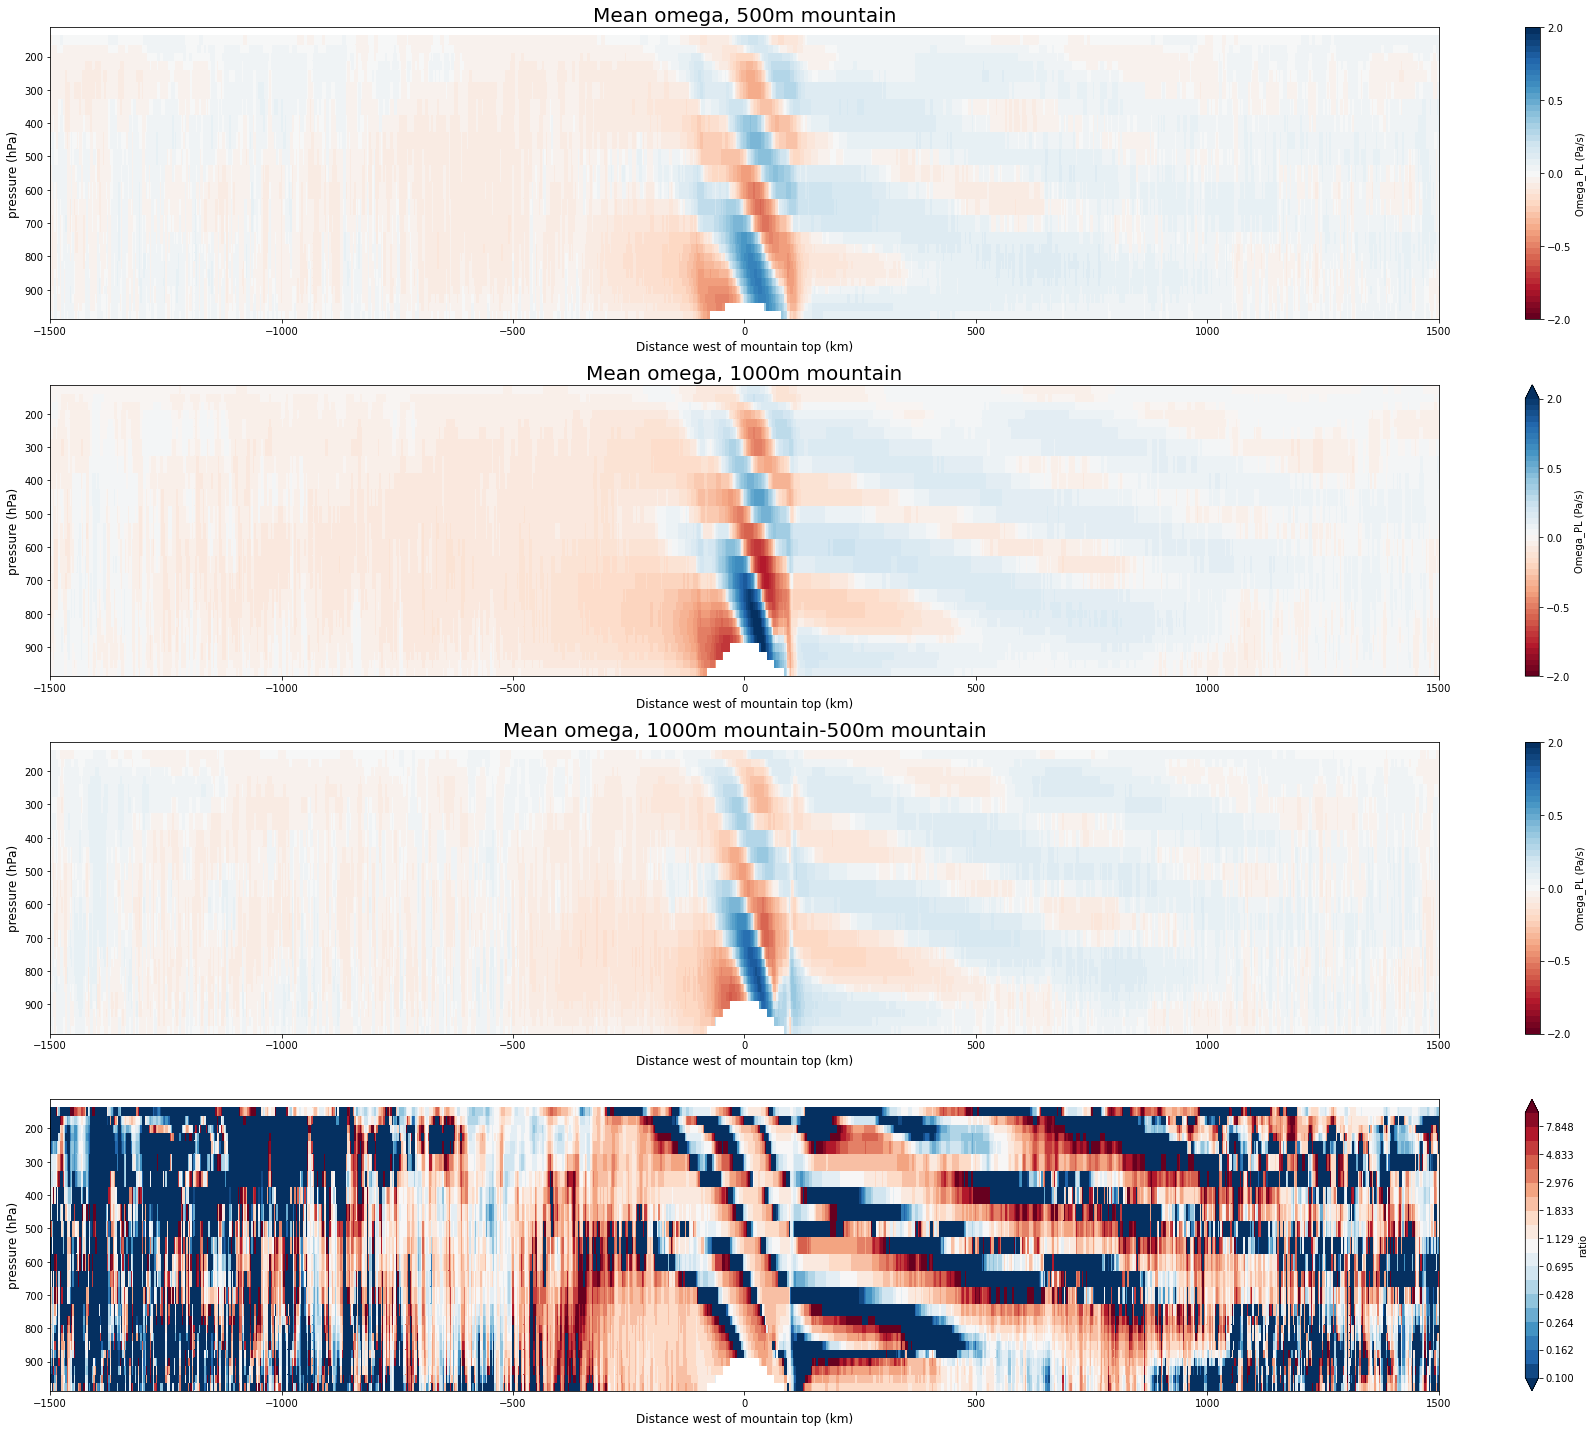

In [28]:
fig,ax=plt.subplots(4,1,figsize=(25,20))
wlevs=f(np.linspace(-(2.)**(1/2),2.**(1/2),50))
wticks=[-2,-.5,0.,.5,2.]


lmomegamean_p.plot(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'},cmap=plt.cm.RdBu)
omegamean_p.plot(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'},cmap=plt.cm.RdBu)
(omegamean_p-lmomegamean_p).plot(ax=ax[2],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'},cmap=plt.cm.RdBu)
(omegamean_p/lmomegamean_p).plot(ax=ax[3],yincrease=False, levels=10**(np.linspace(-1,1,20)),cbar_kwargs={'label':'ratio'},cmap=plt.cm.RdBu_r)



ax[0].set_title("Mean omega, 500m mountain",fontsize=20)
ax[1].set_title("Mean omega, 1000m mountain",fontsize=20)
ax[2].set_title("Mean omega, 1000m mountain-500m mountain",fontsize=20)

for a in ax:
    a.set_xlabel("Distance west of mountain top (km)",fontsize=12)
    a.set_ylabel("pressure (hPa)",fontsize=12)
    a.set_xlim(-1500,1500)
fig.tight_layout()


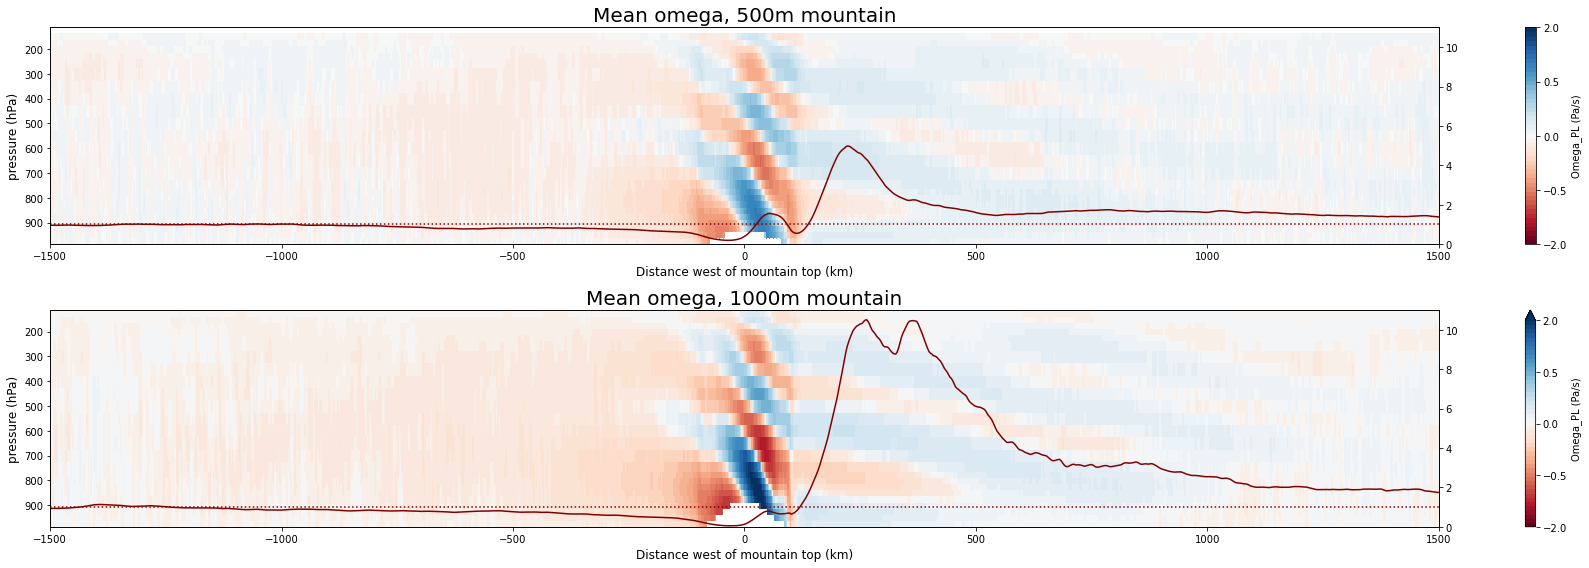

In [96]:
fig,ax=plt.subplots(2,1,figsize=(25,8))
wlevs=f(np.linspace(-(2.)**(1/2),2.**(1/2),50))
wticks=[-2,-.5,0.,.5,2.]


lmomegamean_p.plot(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'},cmap=plt.cm.RdBu)
omegamean_p.plot(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'Omega_PL (Pa/s)'},cmap=plt.cm.RdBu)
ax02=ax[0].twinx()
ax12=ax[1].twinx()

ax02.plot(hrdist,lmfsim[::-1],color='maroon')
ax12.plot(hrdist,hrfsim[::-1],color='maroon')
ax02.axhline(1.,color='maroon',linestyle=':')
ax12.axhline(1.,color='maroon',linestyle=':')
ax02.set_ylim(0.,11.)
ax12.set_ylim(0.,11.)

ax[0].set_title("Mean omega, 500m mountain",fontsize=20)
ax[1].set_title("Mean omega, 1000m mountain",fontsize=20)

for a in ax:
    a.set_xlabel("Distance west of mountain top (km)",fontsize=12)
    a.set_ylabel("pressure (hPa)",fontsize=12)
    a.set_xlim(-1500,1500)
fig.tight_layout()


# Uncertainty on $\tau_c$

In [30]:
def calc_tauc(cape,pr,time1,time2,normalize=0):
    factor = 1/(2.26e6/86400/10000)
    tauc = factor*cape.isel(Time=slice(time1,time2)).mean(['south_north','Time'])/pr.isel(Time=slice(time1,time2)).mean(['south_north','Time'])
    if normalize:
        return tauc/tauc[2000:3000].mean()
    else:
        return tauc

(-3.5, 3.5)

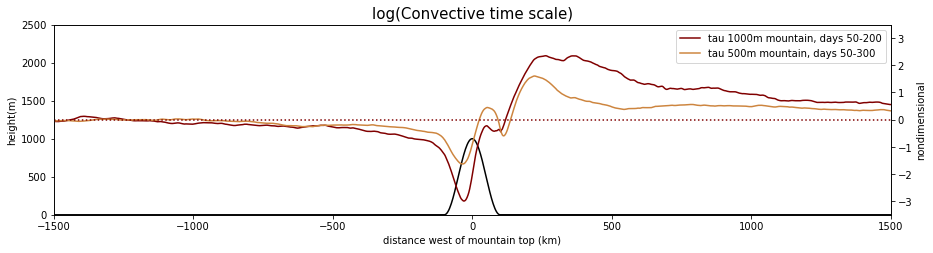

In [44]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,np.log(calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,800,normalize=1)),color='maroon',label='tau 1000m mountain, days 50-200')
ax2.plot(hrdist,np.log(calc_tauc(lmchannel_capecin[0],lmchannelprecip,200,1200,normalize=1)),color='peru',label='tau 500m mountain, days 50-300')
ax2.axhline(0.,linestyle=':',color='maroon'  )

ax2.set_title("log(Convective time scale)", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
ax2.set_ylim(-3.5,3.5)

In [136]:
hrtauc_10day_intervals = np.zeros((15,len(hrchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    hrtauc_10day_intervals[i]=np.array(calc_tauc(hrchannel_capecin[0],hrchannelprecip,t,t+40,normalize=0))
#tauc_5day_intervals = np.zeros((30,len(hrchannel.west_east)))
#for i,t in enumerate(range(200,800,20)):
#    tauc_5day_intervals[i]=np.array(calc_tauc(hrchannel_capecin[0],hrchannelprecip,t,t+20,normalize=0))


In [162]:
lmtauc_10day_intervals = np.zeros((25,len(hrchannel.west_east)))
for i,t in enumerate(range(200,1160,40)):
    lmtauc_10day_intervals[i]=np.array(calc_tauc(lmchannel_capecin[0],lmchannelprecip,t,t+40,normalize=0))

(0.0, 2500.0)

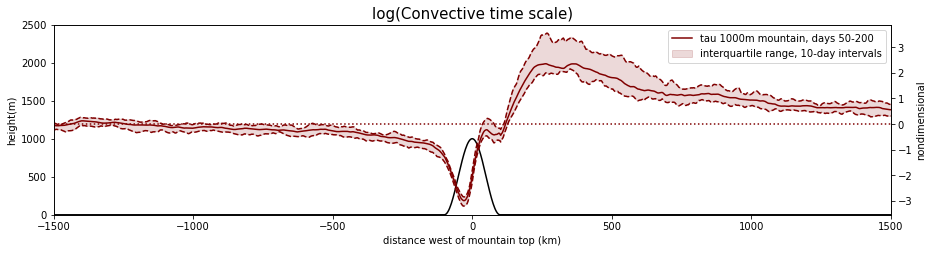

In [163]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,np.log(calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,800,normalize=1)),color='maroon',label='tau 1000m mountain, days 50-200')
pct25=np.log(np.percentile(hrtauc_10day_intervals,25,axis=0)/hrtauc_10day_intervals[:,2000:3000].mean())
pct75=np.log(np.percentile(hrtauc_10day_intervals,75,axis=0)/hrtauc_10day_intervals[:,2000:3000].mean())
ax2.plot(hrdist,pct25,color='maroon',linestyle='--')
ax2.plot(hrdist,pct75,color='maroon',linestyle='--')
ax2.fill_between(hrdist,pct25,pct75,alpha=0.15,color='maroon',label='interquartile range, 10-day intervals')

ax2.axhline(0.,linestyle=':',color='maroon'  )

ax2.set_title("log(Convective time scale)", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(0.,15.)

(0.0, 2500.0)

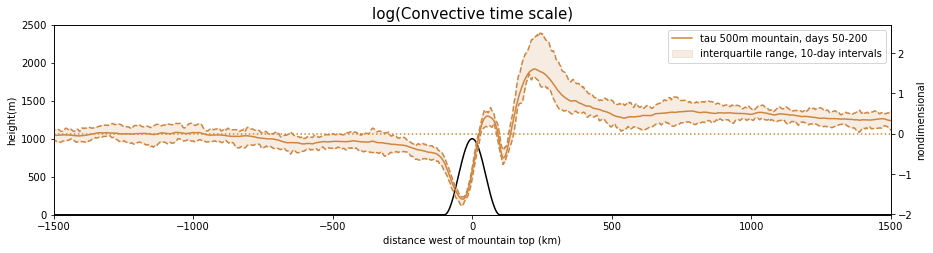

In [164]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,np.log(calc_tauc(lmchannel_capecin[0],lmchannelprecip,200,1160,normalize=1)),color='peru',label='tau 500m mountain, days 50-300')
pct25=np.log(np.percentile(lmtauc_10day_intervals,25,axis=0)/lmtauc_10day_intervals[:,2000:3000].mean())
pct75=np.log(np.percentile(lmtauc_10day_intervals,75,axis=0)/lmtauc_10day_intervals[:,2000:3000].mean())
ax2.plot(hrdist,pct25,color='peru',linestyle='--')
ax2.plot(hrdist,pct75,color='peru',linestyle='--')
ax2.fill_between(hrdist,pct25,pct75,alpha=0.15,color='peru',label='interquartile range, 10-day intervals')

ax2.axhline(0.,linestyle=':',color='peru'  )

ax2.set_title("log(Convective time scale)", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(0.,15.)

(0.0, 2500.0)

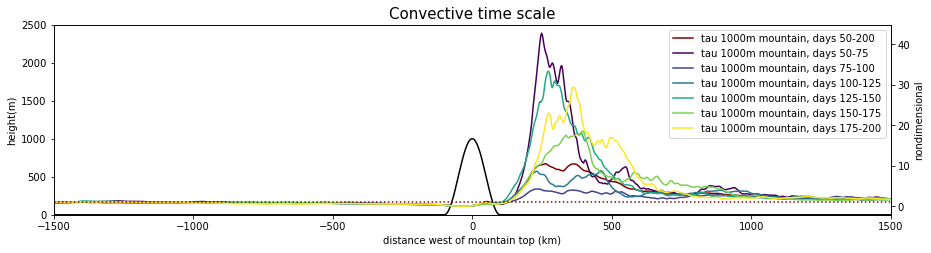

In [112]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,800,normalize=1),color='maroon',label='tau 1000m mountain, days 50-200')
#ax2.plot(hrdist,calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,400,normalize=1),color='maroon',linestyle=':',label='tau 1000m mountain, days 50-100')
#ax2.plot(hrdist,calc_tauc(hrchannel_capecin[0],hrchannelprecip,400,600,normalize=1),color='maroon',linestyle='--',label='tau 1000m mountain, days 100-150')
#ax2.plot(hrdist,calc_tauc(hrchannel_capecin[0],hrchannelprecip,600,800,normalize=1),color='maroon',linestyle='-.',label='tau 1000m mountain, days 150-200')
style=[':','--','-.']
colors=plt.cm.viridis(np.linspace(0,1,6))
for i,t in enumerate(range(200,800,100)):
    ax2.plot(hrdist,calc_tauc(hrchannel_capecin[0],hrchannelprecip,t,t+100,normalize=1),color=colors[i],label='tau 1000m mountain, days %i-%i'%(t//4,t//4+25))

ax2.axhline(1.,linestyle=':',color='maroon'  )

ax2.set_title("Convective time scale", fontsize=15)
ax2.set_ylabel("nondimensional")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(0.,15.)


# RMS w and dry w

 RMS w is $\sqrt{\langle w^2 \rangle}$ (where $\langle \cdot \rangle$ denotes a time and space mean).
 
 Then :
 $\langle w_\mathrm{dry}+w\rangle ^2 = \langle w_\mathrm{dry}\rangle ^2+\langle w\rangle ^2 + 2  \langle w_\mathrm{dry}\rangle \langle w\rangle $
 
$\qquad\qquad\qquad\quad\simeq w_\mathrm{dry} ^2+w_\mathrm{rms}^2$ because $\langle w\rangle  \ll \langle w_\mathrm{dry}\rangle $
 
 Hence $w_\mathrm{rms,mtn} = \sqrt{w_\mathrm{dry} ^2+w_\mathrm{rms}^2}$ and NOT $ w_\mathrm{dry}+w_\mathrm{rms}$

In [20]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
def nonlinear_mountain_wave(h,N,U,x,z):
    """z must be two-dimensional here, dimensions=(pressure,distance_from_mtn)"""
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z2-h[:,None]))+f[:,None]*np.sin(l*(z2-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    return xr.DataArray(w[::-1].transpose(),coords={'pressure':z.pressure,'distance_from_mtn':z.distance_from_mtn},dims=['pressure','distance_from_mtn'])

In [21]:
U=10
N=0.009
lmzmean_p=change_coords_pl(lmchannel_p,lmchannel_p.GHT_PL[-48:].mean(['Time','south_north'])).load()
lmzmean_p=lmzmean_p.where(lmzmean_p>0.)
x = np.array(zmean_p.distance_from_mtn)[::-1]
hrw_nonlinear_s = nonlinear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),zmean_p)
lmw_nonlinear_s = nonlinear_mountain_wave(np.array(lmhgt[::-1]),N,U,1000*(x-x[0]),lmzmean_p)


In [22]:
wrms=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.rms.days50-200.nc")
wrms=change_coords_pl(hrchannel_p,wrms)[1:-4]
wrms=wrms.where(wrms<5)

lmwrms=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.W_PL.rms.days50-200.nc")
lmwrms=change_coords_pl(lmchannel_p,lmwrms)
lmwrms=lmwrms.where(lmwrms<5)

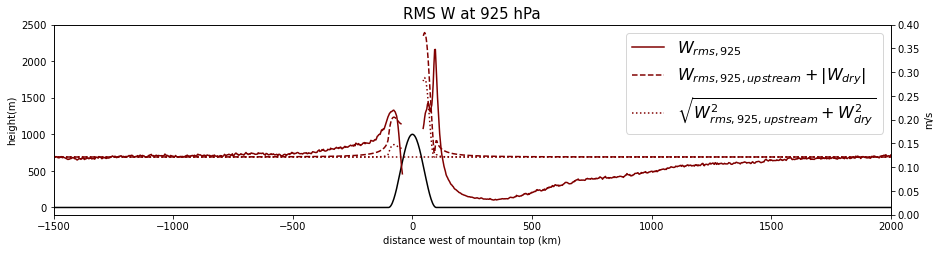

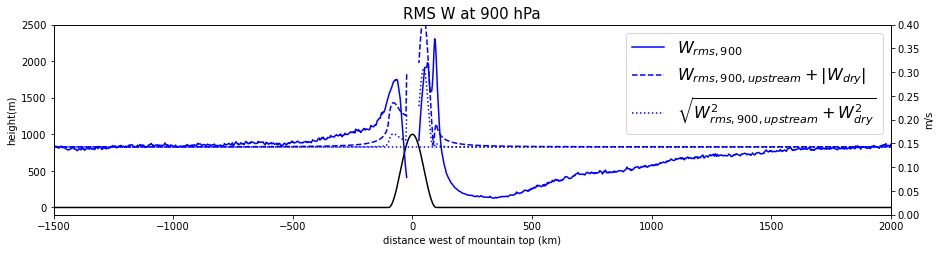

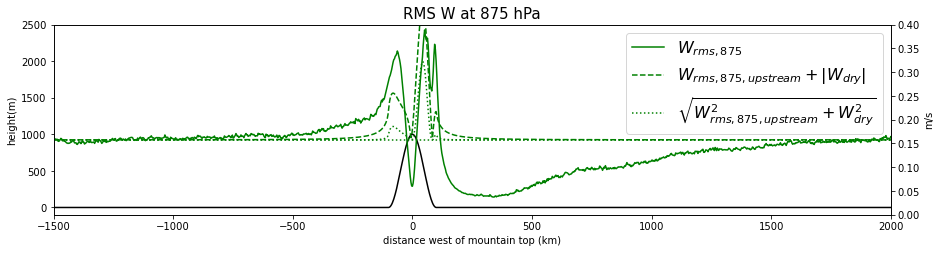

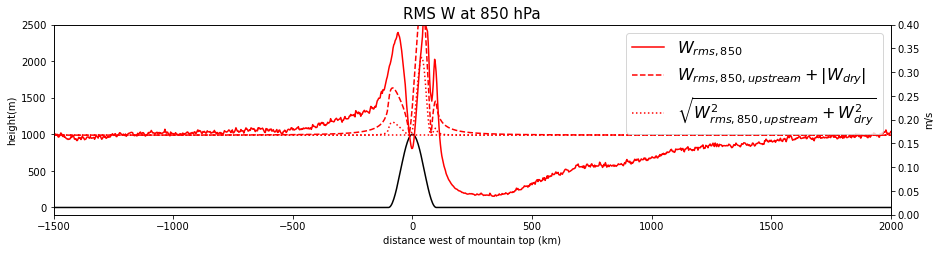

In [25]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    ax2.plot(hrdist,  wrms.sel(pressure=lev),color=colors[0],label=r"$W_{rms,%i}$"%lev)
    ax2.plot(hrdist,  wrms.sel(pressure=lev)[2000:3000].mean()+np.abs(hrw_nonlinear_s.sel(pressure=lev)),color=colors[0],linestyle='--',label=r"$W_{rms,%i,upstream} + |W_{dry}|$"%lev)
    ax2.plot(hrdist,  np.sqrt(wrms.sel(pressure=lev)[2000:3000].mean()**2+hrw_nonlinear_s.sel(pressure=lev)**2),color=colors[0],linestyle=':',label=r"$\sqrt{W_{rms,%i,upstream}^2 + W_{dry}^2}$"%lev)
      
    ax2.axhline(wrms.sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[0]  )
    ax2.set_title("RMS W at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("m/s")
    ax2.legend(fontsize=16)
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(0.,0.4)


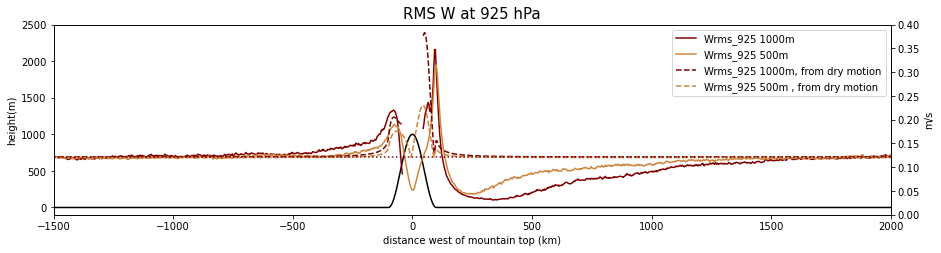

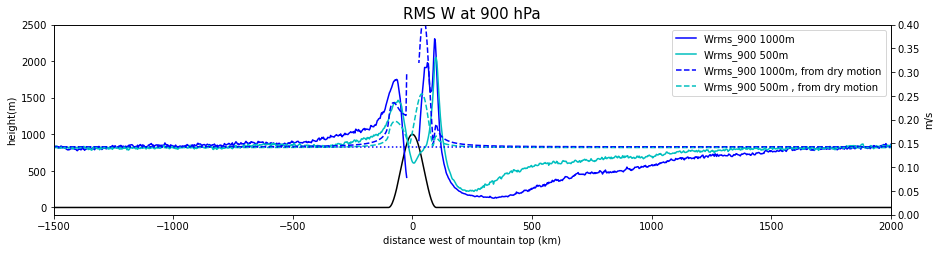

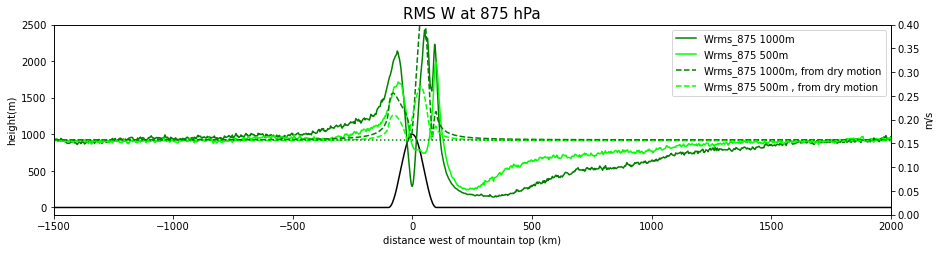

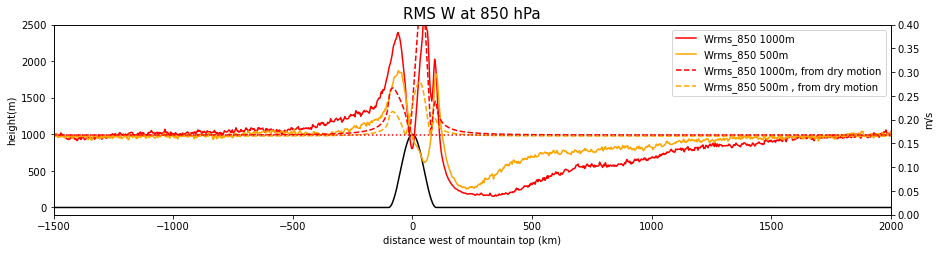

In [32]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    ax2.plot(hrdist,  wrms.sel(pressure=lev),color=colors[0],label="Wrms_%i 1000m"%lev)
    ax2.plot(hrdist,lmwrms.sel(pressure=lev),color=colors[1],label="Wrms_%i 500m"%lev)

    ax2.plot(hrdist,  wrms.sel(pressure=lev)[2000:3000].mean()+np.abs(hrw_nonlinear_s.sel(pressure=lev)),color=colors[0],linestyle='--',label="Wrms_%i 1000m, from dry motion"%lev)
    ax2.plot(hrdist,lmwrms.sel(pressure=lev)[2000:3000].mean()+np.abs(lmw_nonlinear_s.sel(pressure=lev)),color=colors[1],linestyle='--',label="Wrms_%i 500m , from dry motion"%lev)
    #ax2.plot(hrdist,  wrms.sel(pressure=lev)[2000:3000].mean()+np.abs(  wmean_p.sel(pressure=lev)),color=colors[0],linestyle=':',label="Wrms_%i 1000m, from dry motion"%lev)
    #ax2.plot(hrdist,lmwrms.sel(pressure=lev)[2000:3000].mean()+np.abs(lmwmean_p.sel(pressure=lev)),color=colors[1],linestyle=':',label="Wrms_%i 500m , from dry motion"%lev)
        
    ax2.axhline(wrms.sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[0]  )
    ax2.set_title("RMS W at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("m/s")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(0.,0.4)


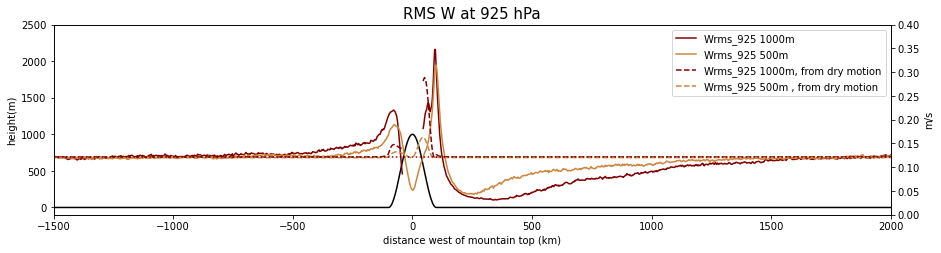

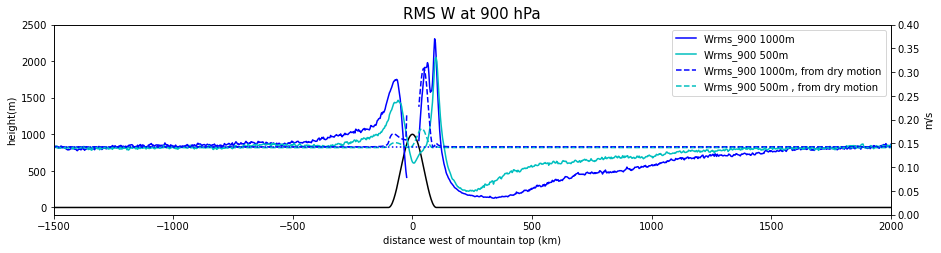

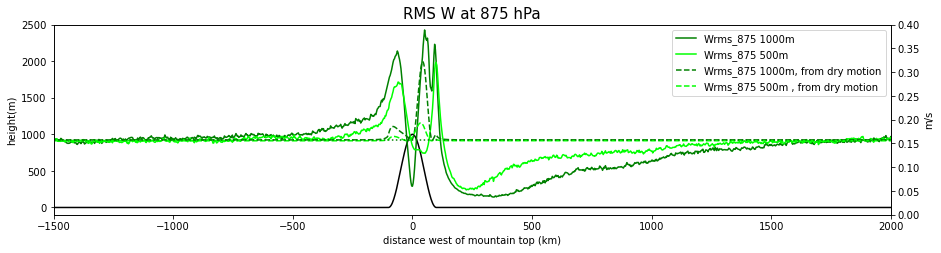

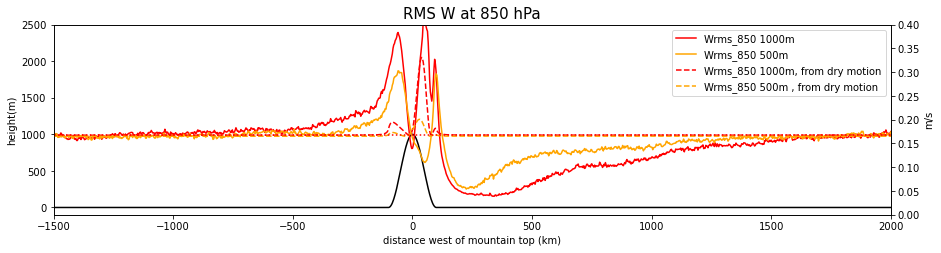

In [31]:
for lev,colors in zip([925,900,875,850],[('maroon','peru'),('b','c'),('g','lime'),('r','orange')]):
    ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
    ax2.plot(hrdist,  wrms.sel(pressure=lev),color=colors[0],label="Wrms_%i 1000m"%lev)
    ax2.plot(hrdist,lmwrms.sel(pressure=lev),color=colors[1],label="Wrms_%i 500m"%lev)

    ax2.plot(hrdist,np.sqrt(  wrms.sel(pressure=lev)[2000:3000].mean()**2+hrw_nonlinear_s.sel(pressure=lev)**2),color=colors[0],linestyle='--',label="Wrms_%i 1000m, from dry motion"%lev)
    ax2.plot(hrdist,np.sqrt(lmwrms.sel(pressure=lev)[2000:3000].mean()**2+lmw_nonlinear_s.sel(pressure=lev)**2),color=colors[1],linestyle='--',label="Wrms_%i 500m , from dry motion"%lev)
    #ax2.plot(hrdist,np.sqrt(  wrms.sel(pressure=lev)[2000:3000].mean()**2+  wmean_p.sel(pressure=lev)**2),color=colors[0],linestyle=':',label="Wrms_%i 1000m, from dry motion"%lev)
    #ax2.plot(hrdist,np.sqrt(lmwrms.sel(pressure=lev)[2000:3000].mean()**2+lmwmean_p.sel(pressure=lev)**2),color=colors[1],linestyle=':',label="Wrms_%i 500m , from dry motion"%lev)
        
    ax2.axhline(wrms.sel(pressure=lev)[2000:3000].mean(),linestyle=':',color=colors[0]  )
    ax2.set_title("RMS W at %i hPa"%lev, fontsize=15)
    ax2.set_ylabel("m/s")
    ax2.legend()
    ax.set_ylim(-100,2500)
    ax.set_xlim(-1500,2000)
    ax2.set_ylim(0.,0.4)


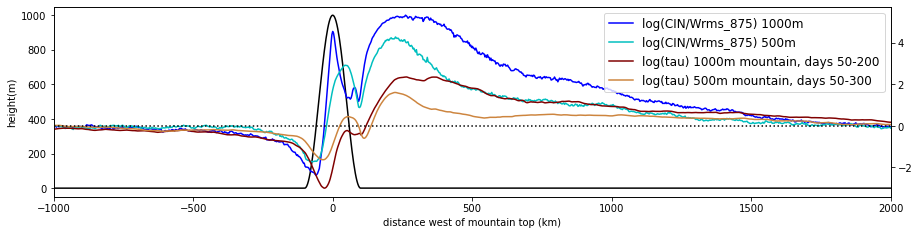

In [35]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
wrms_test_adim =   wrms.sel(pressure=875)/  wrms.sel(pressure=875)[2000:3000].mean()
lmwrms_test_adim = lmwrms.sel(pressure=875)/lmwrms.sel(pressure=875)[2000:3000].mean()
ax2.plot(hrdist,np.log(change_coords_sfc(hrcin_adim)/  wrms_test_adim**2),color='b',label="log(CIN/Wrms_875) 1000m")
ax2.plot(hrdist,np.log(change_coords_sfc(lmcin_adim)/lmwrms_test_adim**2),color='c',label="log(CIN/Wrms_875) 500m" )

ax2.plot(hrdist,np.log(calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,800,normalize=1)),color='maroon',label='log(tau) 1000m mountain, days 50-200')
ax2.plot(hrdist,np.log(calc_tauc(lmchannel_capecin[0],lmchannelprecip,200,1200,normalize=1)),color='peru',label= 'log(tau) 500m mountain, days 50-300')
ax2.axhline(0.,linestyle=':',color='k')
ax.set_xlim(-1000,2000)
ax2.legend(fontsize=12)

(-1000.0, 2000.0)

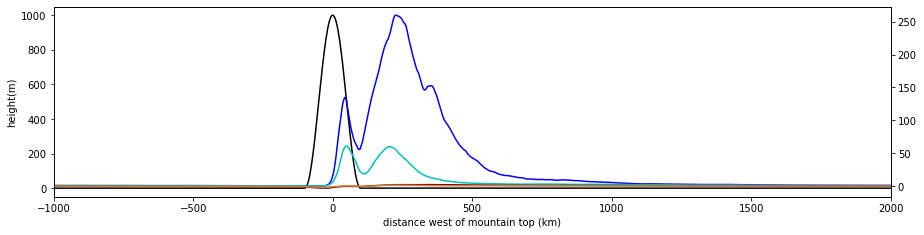

In [58]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
wrms_test_adim =   wrms.sel(pressure=875)/  wrms.sel(pressure=875)[2000:3000].mean()
lmwrms_test_adim = lmwrms.sel(pressure=875)/lmwrms.sel(pressure=875)[2000:3000].mean()
ax2.plot(hrdist,hrcin_adim/hrchannelprecip[200:800].mean(['Time','south_north'] )*4.5,color='b',label="log(CIN/Wrms_875) 1000m")
ax2.plot(hrdist,lmcin_adim/lmchannelprecip[200:1200].mean(['Time','south_north'])*4.5,color='c',label="log(CIN/Wrms_875) 500m" )

ax2.plot(hrdist,np.log(calc_tauc(hrchannel_capecin[0],hrchannelprecip,200,800,normalize=1)),color='maroon',label='log(tau) 1000m mountain, days 50-200')
ax2.plot(hrdist,np.log(calc_tauc(lmchannel_capecin[0],lmchannelprecip,200,1200,normalize=1)),color='peru',label= 'log(tau) 500m mountain, days 50-300')

ax.set_xlim(-1000,2000)

# Extreme precip

In [170]:
%%time
hrchannelprecip95=hrchannelprecip.isel(Time=slice(200,800)).quantile(0.95,'Time')
lmchannelprecip95=lmchannelprecip.isel(Time=slice(200,1200)).quantile(0.95,'Time')

CPU times: user 1min 9s, sys: 891 ms, total: 1min 10s
Wall time: 1min 10s


In [177]:
%%time
hrchannelprecip99=hrchannelprecip.isel(Time=slice(200,800)).quantile(0.99,'Time')
lmchannelprecip99=lmchannelprecip.isel(Time=slice(200,1200)).quantile(0.99,'Time')

CPU times: user 1min 10s, sys: 329 ms, total: 1min 10s
Wall time: 1min 10s


(0.0, 2500.0)

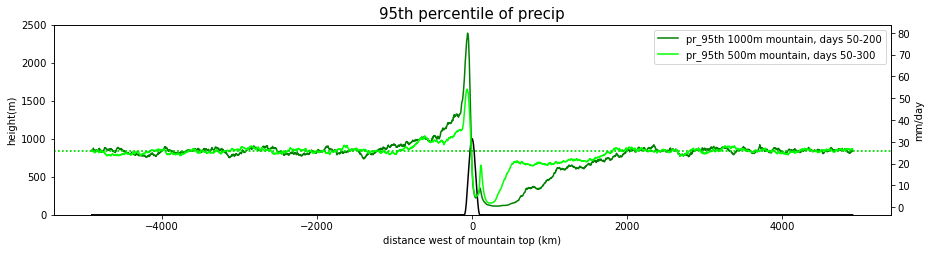

In [172]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,hrchannelprecip95.mean('south_north'),color='green',label='pr_95th 1000m mountain, days 50-200')
ax2.plot(hrdist,lmchannelprecip95.mean('south_north'),color='lime',label='pr_95th 500m mountain, days 50-300')
ax2.axhline(hrchannelprecip95[:,2000:3000].mean(),linestyle=':',color='green')
ax2.axhline(lmchannelprecip95[:,2000:3000].mean(),linestyle=':',color='lime')


ax2.set_title("95th percentile of precip", fontsize=15)
ax2.set_ylabel("mm/day")
ax2.legend()
#ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(-3.5,3.5)

(0.0, 2500.0)

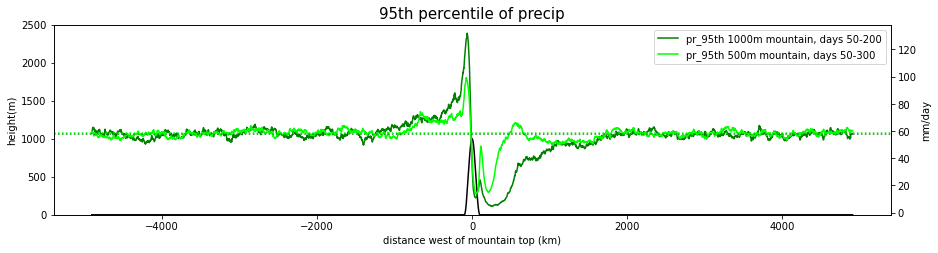

In [181]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,hrchannelprecip99.mean('south_north'),color='green',label='pr_95th 1000m mountain, days 50-200')
ax2.plot(hrdist,lmchannelprecip99.mean('south_north'),color='lime',label='pr_95th 500m mountain, days 50-300')
ax2.axhline(hrchannelprecip99[:,2000:3000].mean(),linestyle=':',color='green')
ax2.axhline(lmchannelprecip99[:,2000:3000].mean(),linestyle=':',color='lime')


ax2.set_title("95th percentile of precip", fontsize=15)
ax2.set_ylabel("mm/day")
ax2.legend()
#ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(-3.5,3.5)

(0.0, 2500.0)

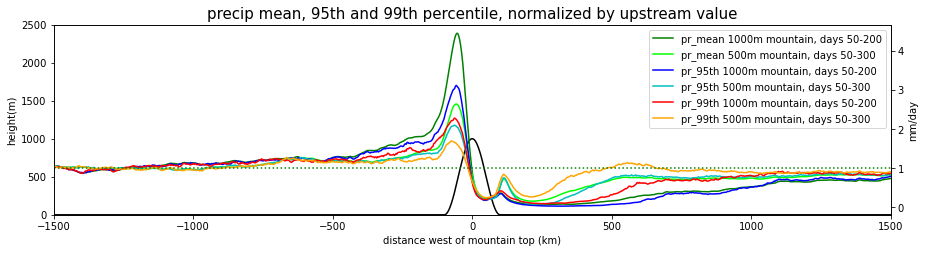

In [180]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,hrpr/hrpr[2000:3000].mean(),color='green',label='pr_mean 1000m mountain, days 50-200')
ax2.plot(hrdist,lmpr/lmpr[2000:3000].mean(),color='lime',label='pr_mean 500m mountain, days 50-300')
ax2.plot(hrdist,hrchannelprecip95.mean('south_north')/hrchannelprecip95[:,2000:3000].mean(),color='blue',label='pr_95th 1000m mountain, days 50-200')
ax2.plot(hrdist,lmchannelprecip95.mean('south_north')/lmchannelprecip95[:,2000:3000].mean(),color='c',label='pr_95th 500m mountain, days 50-300')
ax2.plot(hrdist,hrchannelprecip99.mean('south_north')/hrchannelprecip99[:,2000:3000].mean(),color='red',label='pr_99th 1000m mountain, days 50-200')
ax2.plot(hrdist,lmchannelprecip99.mean('south_north')/lmchannelprecip99[:,2000:3000].mean(),color='orange',label='pr_99th 500m mountain, days 50-300')


ax2.axhline(1.,linestyle=':',color='green')

ax2.set_title("precip mean, 95th and 99th percentile, normalized by upstream value", fontsize=15)
ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(-3.5,3.5)